<h1>Table of Contents</h1>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    <ol>
        <li><a href="#import_libraries">Import Libraries</a></li>
        <li><a href="#import_dataset">Import Stroke Prediction Dataset</a></li>
        <li><a href="#eda">Exploratory Data Analysis (EDA)</a></li>                      
    </ol>
</div>
<br>
<hr>

<div id="import_libraries">
    <h2>Import Libraries</h2>    
</div>

In [1]:
!pip install mlxtend

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 19.1 MB/s eta 0:00:00


In [2]:
import os
import torch
import psutil

print(f"Number of vCPUs: {os.cpu_count()}")  # Or use psutil

if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    print(f"GPU Name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
    device = torch.cuda.current_device()
    props = torch.cuda.get_device_properties(device)
    print(f"Total VRAM: {props.total_memory / (1024 ** 3):.2f} GB")
else:
    print("GPU not available")

Number of vCPUs: 96
GPU not available


In this environment, we utilize Google's Colab with a v2-8 TPU, which provides 96 vCPUs; however, GPU acceleration is not available for data processing and visualization libraries such as pandas, matplotlib, or mlxtend

<hr>
<div id="import_dataset">
    <h2>Import Stroke Prediction Dataset</h2>         
</div>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.frequent_patterns import fpgrowth, association_rules

import warnings
warnings.filterwarnings("ignore")

> Dataset Overview

The "Healthcare Stroke Prediction" dataset (collected from Kaggle (https://www.kaggle.com/datasets/aouatifcherdid/healthcare-dataset-stroke-data/data)) contains medical and demographic information of patients, aimed at predicting the likelihood of stroke occurrence. It includes features such as age, gender, health conditions, and lifestyle indicators.

> Project Objective

The goal of this project is to apply **association rule mining** to uncover meaningful patterns and co-occurring factors related to stroke risk. These insights can support healthcare decision-making and preventive strategies.

> Dataset Metadata

| Feature Name        | Description                                                                 |
|---------------------|-----------------------------------------------------------------------------|
| id                  | Unique identifier for each patient                                          |
| gender              | Gender of the patient (Male, Female, Other)                                 |
| age                 | Age of the patient                                                          |
| hypertension        | 1 if the patient has hypertension, 0 otherwise                              |
| heart_disease       | 1 if the patient has any heart disease, 0 otherwise                         |
| ever_married        | Marital status of the patient (Yes/No)                                     |
| work_type           | Type of occupation (e.g., Private, Self-employed, Govt job, etc.)           |
| Residence_type      | Urban or Rural residence                                                    |
| avg_glucose_level   | Average glucose level in blood                                              |
| bmi                 | Body Mass Index                                                             |
| smoking_status      | Smoking status (e.g., formerly smoked, never smoked, smokes, Unknown)       |
| stroke              | Target variable: 1 if the patient had a stroke, 0 otherwise                 |

In [4]:
url = "/content/healthcare-dataset-stroke-data.csv"
df_stroke = pd.read_csv(url)
display(df_stroke.head())

id  gender   age  hypertension  heart_disease ever_married  \
0  30669    Male   3.0             0              0           No   
1  30468    Male  58.0             1              0          Yes   
2  16523  Female   8.0             0              0           No   
3  56543  Female  70.0             0              0          Yes   
4  46136    Male  14.0             0              0           No   

      work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0      children          Rural              95.12  18.0              NaN   
1       Private          Urban              87.96  39.2     never smoked   
2       Private          Urban             110.89  17.6              NaN   
3       Private          Rural              69.04  35.9  formerly smoked   
4  Never_worked          Rural             161.28  19.1              NaN   

   stroke  
0       0  
1       0  
2       0  
3       0  
4       0

In [5]:
# Get the shape of the dataset, which returns the number of rows and columns
shape_of_the_dataset = df_stroke.shape
print("\nThe shape of the dataset -->", shape_of_the_dataset)


The shape of the dataset --> (43400, 12)


<hr>
<div id="eda">
    <h2>Exploratory Data Analysis (EDA)</h2>    
</div>
<div>
    <ol>
        <li><a href="#summary_statistics">Summary Statistics</a></li>        
        <li><a href="#detect_duplicate">Detect Duplicate Rows</a></li>
        <li><a href="#identify_missing_values">Identify Missing Values</a></li>       
        <li><a href="#univariate_analysis">Univariate Analysis</a></li>
        <li><a href="#bivariate_analysis">Bivariate Analysis</a></li>
        <li><a href="#correlation_analysis">Correlation Analysis</a></li>
        <li><a href="#detect_outliers">Detect Outliers</a></li>                              
    </ol>
</div>
<br>

<hr>
<div id="summary_statistics">
    <h2>Summary Statistics</h2>    
</div>

In [6]:
# Display a concise summary of the dataset
# This summary includes the index dtype, column dtypes, non-null values, and memory usage
print('\nMore information about the dataset:\n')

data_information = df_stroke.info()
display(data_information)


More information about the dataset:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 43400 non-null  int64  
 1   gender             43400 non-null  object 
 2   age                43400 non-null  float64
 3   hypertension       43400 non-null  int64  
 4   heart_disease      43400 non-null  int64  
 5   ever_married       43400 non-null  object 
 6   work_type          43400 non-null  object 
 7   Residence_type     43400 non-null  object 
 8   avg_glucose_level  43400 non-null  float64
 9   bmi                41938 non-null  float64
 10  smoking_status     30108 non-null  object 
 11  stroke             43400 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 4.0+ MB


None

In [7]:
# Show summary statistics for the dataset
# This includes count, mean, standard deviation, minimum, 25%, 50%, 75%, and maximum values for numeric columns
# This includes count, unique(the number of unique values), top(the mode) and the frequency of the top value for object columns
print('\nThe dataset description:\n')

data_describe = df_stroke.describe(include = 'all')
display(data_describe)


The dataset description:



id  gender           age  hypertension  heart_disease  \
count   43400.000000   43400  43400.000000  43400.000000   43400.000000   
unique           NaN       3           NaN           NaN            NaN   
top              NaN  Female           NaN           NaN            NaN   
freq             NaN   25665           NaN           NaN            NaN   
mean    36326.142350     NaN     42.217894      0.093571       0.047512   
std     21072.134879     NaN     22.519649      0.291235       0.212733   
min         1.000000     NaN      0.080000      0.000000       0.000000   
25%     18038.500000     NaN     24.000000      0.000000       0.000000   
50%     36351.500000     NaN     44.000000      0.000000       0.000000   
75%     54514.250000     NaN     60.000000      0.000000       0.000000   
max     72943.000000     NaN     82.000000      1.000000       1.000000   

       ever_married work_type Residence_type  avg_glucose_level           bmi  \
count         43400     43400          43400       43400.000000  41938.000000   
unique            2         5              2                NaN           NaN   
top             Yes   Private          Urban                NaN           NaN   
freq          27938     24834          21756                NaN           NaN   
mean            NaN       NaN            NaN         104.482750     28.605038   
std             NaN       NaN            NaN          43.111751      7.770020   
min             NaN       NaN            NaN          55.000000     10.100000   
25%             NaN       NaN            NaN          77.540000     23.200000   
50%             NaN       NaN            NaN          91.580000     27.700000   
75%             NaN       NaN            NaN         112.070000     32.900000   
max             NaN       NaN            NaN         291.050000     97.600000   

       smoking_status        stroke  
count           30108  43400.000000  
unique              3           NaN  
top      never smoked           NaN  
freq            16053           NaN  
mean              NaN      0.018041  
std               NaN      0.133103  
min               NaN      0.000000  
25%               NaN      0.000000  
50%               NaN      0.000000  
75%               NaN      0.000000  
max               NaN      1.000000

#### Unique label / Value investigation

In [8]:
# check the number of unique values for each features
# and whether each entries is unique
df_stroke.nunique()

id                   43400
gender                   3
age                    104
hypertension             2
heart_disease            2
ever_married             2
work_type                5
Residence_type           2
avg_glucose_level    12543
bmi                    555
smoking_status           3
stroke                   2
dtype: int64

We can see that each entries has an unique id, thus it is safe to say there aren't any duplicate entries and all entries are unique. Moreover, all feature variables except [age, avg_glucose_level, bmi] only have a few unique values and therefore might be treated as categorical variables.

In [9]:
# Inspect the likely categorical variables
likely_cat_col = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for col in likely_cat_col:
    print(f"{col}:", df_stroke[col].unique())

gender: ['Male' 'Female' 'Other']
ever_married: ['No' 'Yes']
work_type: ['children' 'Private' 'Never_worked' 'Self-employed' 'Govt_job']
Residence_type: ['Rural' 'Urban']
smoking_status: [nan 'never smoked' 'formerly smoked' 'smokes']


Now let's us verify if [hypertension, heart_disease, stroke] are boolean [0,1] variable

In [10]:
# Inspect the likely boolean variables
likely_bool_col = ['hypertension', 'heart_disease', 'stroke']

for col in likely_bool_col:
    print(f"{col}:", df_stroke[col].unique())

hypertension: [0 1]
heart_disease: [0 1]
stroke: [0 1]


We therefore conclude that ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'] can indeed be treated as categorical variables, whereas ['hypertension', 'heart_disease', 'stroke'] as boolean.

In [11]:
# Summary stats for numerical columns, i.e [age, avg_glucose_level, bmi]
numeric_col = ['age', 'avg_glucose_level', 'bmi']
df_stroke[numeric_col].describe()

age  avg_glucose_level           bmi
count  43400.000000       43400.000000  41938.000000
mean      42.217894         104.482750     28.605038
std       22.519649          43.111751      7.770020
min        0.080000          55.000000     10.100000
25%       24.000000          77.540000     23.200000
50%       44.000000          91.580000     27.700000
75%       60.000000         112.070000     32.900000
max       82.000000         291.050000     97.600000

Some outliers can be seen in these 3 feature variables. For instance, age=0.08, avg_glucose_level=291.05.

#### Simple checking on aberrant/non-acceptable data inputs
1. Check if all data in numeric variable columns are non-negative (['age', 'avg_glucose_level', 'bmi'] do not make sense if they are negative)

In [12]:
print(f"Number of negative value entries")
for num_var in numeric_col:
    non_neg_check = df_stroke[num_var].dropna().apply(lambda x: 0 if x>=0 else 1)
    print(f"{num_var}: {non_neg_check.sum()}")

Number of negative value entries
age: 0
avg_glucose_level: 0
bmi: 0


For instance, we can check if the patients of [work_type=children] are really children by checking the ages of the subgroup.

In [13]:
df_stroke[df_stroke.work_type=='children'].age.max()

np.float64(16.0)

In [14]:
# Figures inline and set visualisation style
%matplotlib inline
sns.set()

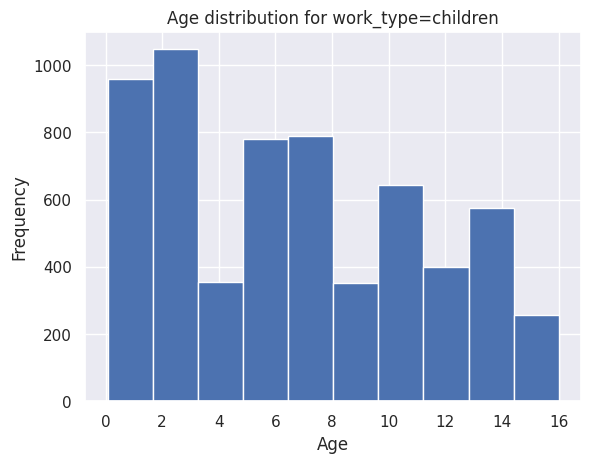

In [15]:
df_stroke[df_stroke.work_type=='children'].age.plot(kind='hist')
plt.xlabel('Age')
plt.title("Age distribution for work_type=children")
plt.show()

<hr>
<div id="detect_duplicate">
    <h2>Detect Duplicate Rows</h2>    
</div>

In [16]:
# Calculate the number of duplicate rows in the dataframe
Num_of_duplicate_rows = df_stroke.duplicated().sum()
print("\nThe number of duplicate rows -->", Num_of_duplicate_rows)


The number of duplicate rows --> 0


<hr>
<div id="identify_missing_values">
    <h2>Identify Missing Values</h2>    
</div>

In [17]:
# Check for missing values in the dataframe
isna = pd.DataFrame(df_stroke.isnull().sum(axis=0))
print(isna)

                       0
id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                 1462
smoking_status     13292
stroke                 0


In [18]:
# Calculate the percentage of missing values for each column
missing_percent = df_stroke.isnull().sum() / len(df_stroke) * 100

print(f"\nPercentage of missing values in each column:\n{missing_percent}")


Percentage of missing values in each column:
id                    0.000000
gender                0.000000
age                   0.000000
hypertension          0.000000
heart_disease         0.000000
ever_married          0.000000
work_type             0.000000
Residence_type        0.000000
avg_glucose_level     0.000000
bmi                   3.368664
smoking_status       30.626728
stroke                0.000000
dtype: float64


In [19]:
# Display rows with missing values
rows_with_missing = df_stroke[df_stroke.isna().any(axis=1)]
print("\nRows with missing values:")
display(rows_with_missing)


Rows with missing values:


id  gender   age  hypertension  heart_disease ever_married  \
0      30669    Male   3.0             0              0           No   
2      16523  Female   8.0             0              0           No   
4      46136    Male  14.0             0              0           No   
5      32257  Female  47.0             0              0          Yes   
10     10460  Female  79.0             0              0          Yes   
...      ...     ...   ...           ...            ...          ...   
43385   5366  Female  66.0             0              0          Yes   
43388  31321  Female  64.0             1              0          Yes   
43389  30759    Male  14.0             0              0           No   
43391  30077    Male   6.0             0              0           No   
43392  45266  Female  18.0             0              0           No   

           work_type Residence_type  avg_glucose_level   bmi smoking_status  \
0           children          Rural              95.12  18.0            NaN   
2            Private          Urban             110.89  17.6            NaN   
4       Never_worked          Rural             161.28  19.1            NaN   
5            Private          Urban             210.95  50.1            NaN   
10          Govt_job          Urban              77.08  35.0            NaN   
...              ...            ...                ...   ...            ...   
43385  Self-employed          Urban              92.10  24.8            NaN   
43388       Govt_job          Rural             228.43   NaN         smokes   
43389       children          Urban              82.48  24.8            NaN   
43391       children          Urban              77.48  19.1            NaN   
43392        Private          Urban             131.96  22.8            NaN   

       stroke  
0           0  
2           0  
4           0  
5           0  
10          0  
...       ...  
43385       0  
43388       0  
43389       0  
43391       0  
43392       0  

[14328 rows x 12 columns]

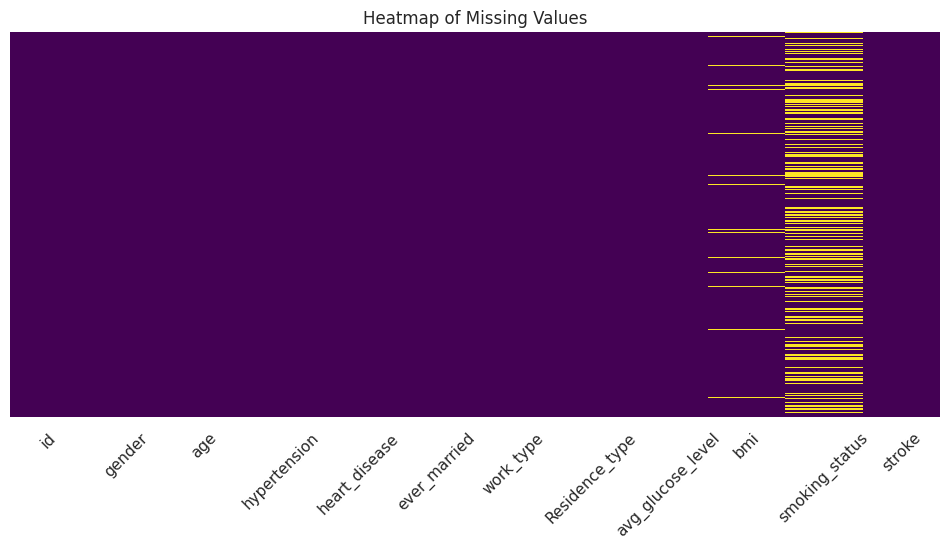

In [20]:
# Plot a heatmap to visualize missing values
# Set figure size
plt.figure(figsize=(12, 5))

# Plot the heatmap
sns.heatmap(df_stroke.isna(), cbar=False, cmap="viridis")

# Set titles and labels
plt.title("Heatmap of Missing Values")
plt.xticks(rotation=45)
plt.yticks([])
plt.ylabel('')
plt.show()

<hr>
<div id="univariate_analysis">
    <h2>Univariate Analysis</h2>    
</div>
<div>
    <ol>
        <li><a href="#numerical_features">UA for Numerical Features</a></li>
        <li><a href="#categorical_features">UA for Categorical Features</a></li>                
    </ol>
</div>
<br>

<div id="numerical_features">
    <h2>UA for Numerical Features</h2>    
</div>

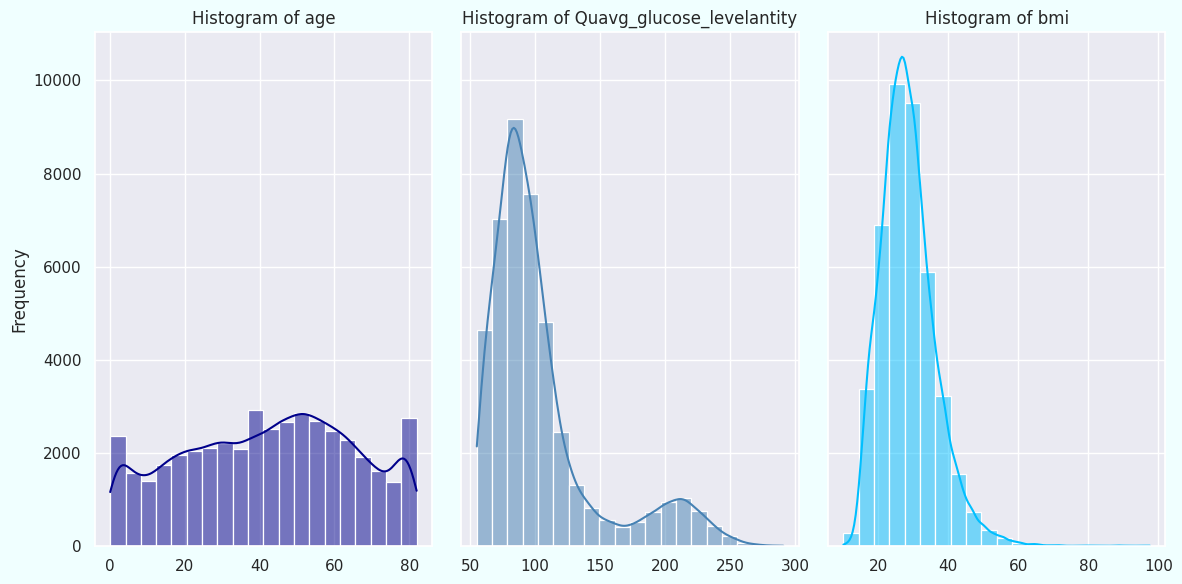

In [21]:
# Plot a histogram for numerical features
# Set up the figure with 1 row and 3 columns for histograms, sharing the y-axis
fig, axes = plt.subplots(1, 3, figsize=(12, 6), sharey=True, facecolor='azure')                      # Set the figure size (width, height)

# Create the first histogram for 'age' with KDE
sns.histplot(df_stroke['age'], bins=20, kde=True, color='darkblue', ax=axes[0])
axes[0].set_title('Histogram of age')
axes[0].set_xlabel('')
axes[0].set_ylabel('Frequency')

# Create the second histogram for 'avg_glucose_level' with KDE
sns.histplot(df_stroke['avg_glucose_level'], bins=20, kde=True, color='steelblue', ax=axes[1])
axes[1].set_title('Histogram of Quavg_glucose_levelantity')
axes[1].set_xlabel('')
axes[1].set_ylabel('')

# Create the third histogram for 'bmi' with KDE
sns.histplot(df_stroke['bmi'], bins=20, kde=True, color='deepskyblue', ax=axes[2])
axes[2].set_title('Histogram of bmi')
axes[2].set_xlabel('')
axes[2].set_ylabel('')

plt.tight_layout()           # Adjust the spacing between plots
plt.show()

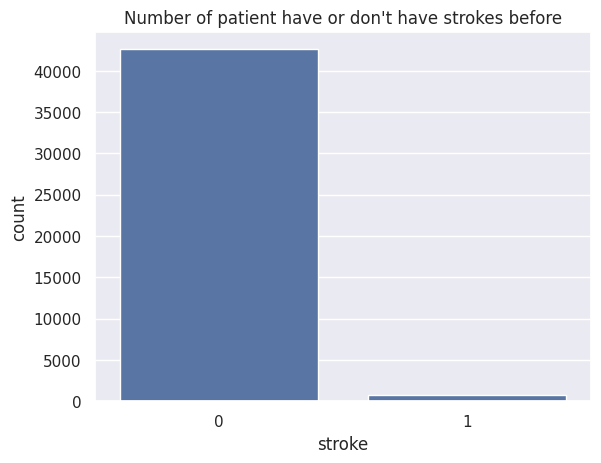

In [22]:
# Bar plot of the number of people have or don't have strokes before
sns.countplot(x='stroke', data=df_stroke)
plt.title("Number of patient have or don't have strokes before")
plt.show()

In [23]:
print('Probability of a patient within the whole dataset having strokes: ')
prob_stroke_whole = df_stroke.stroke.mean()
print(prob_stroke_whole)

Probability of a patient within the whole dataset having strokes: 
0.01804147465437788


In [24]:
print('Sum of a patient within the whole dataset having strokes: ')
sum_stroke_whole = df_stroke.stroke.sum()
print(sum_stroke_whole)

Sum of a patient within the whole dataset having strokes: 
783


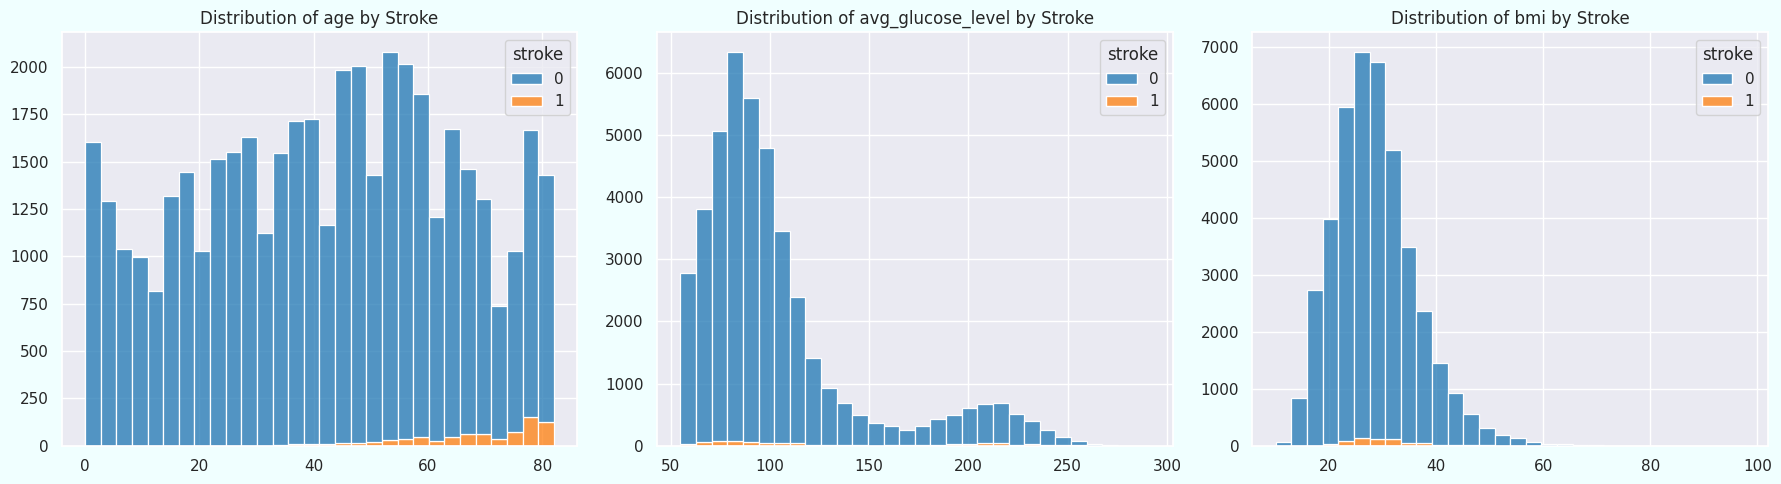

In [25]:
# Plot histograms for numerical features with hue='stroke'
# Set numerical features
numerical_features = ['age', 'avg_glucose_level', 'bmi']

# Plot histograms with hue='stroke'
plt.figure(figsize=(18, 5), facecolor='azure')
for i, feature in enumerate(numerical_features, 1):
    ax = plt.subplot(1, 3, i)
    sns.histplot(data=df_stroke, x=feature, hue='stroke', bins=30,             # Color by 'stroke'
                 palette='tab10', kde=False, multiple='stack', ax=ax)

    # Set title and labels
    ax.set_title(f'Distribution of {feature} by Stroke')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

<div id="categorical_features">
    <h2>UA for Categorical Features</h2>    
</div>

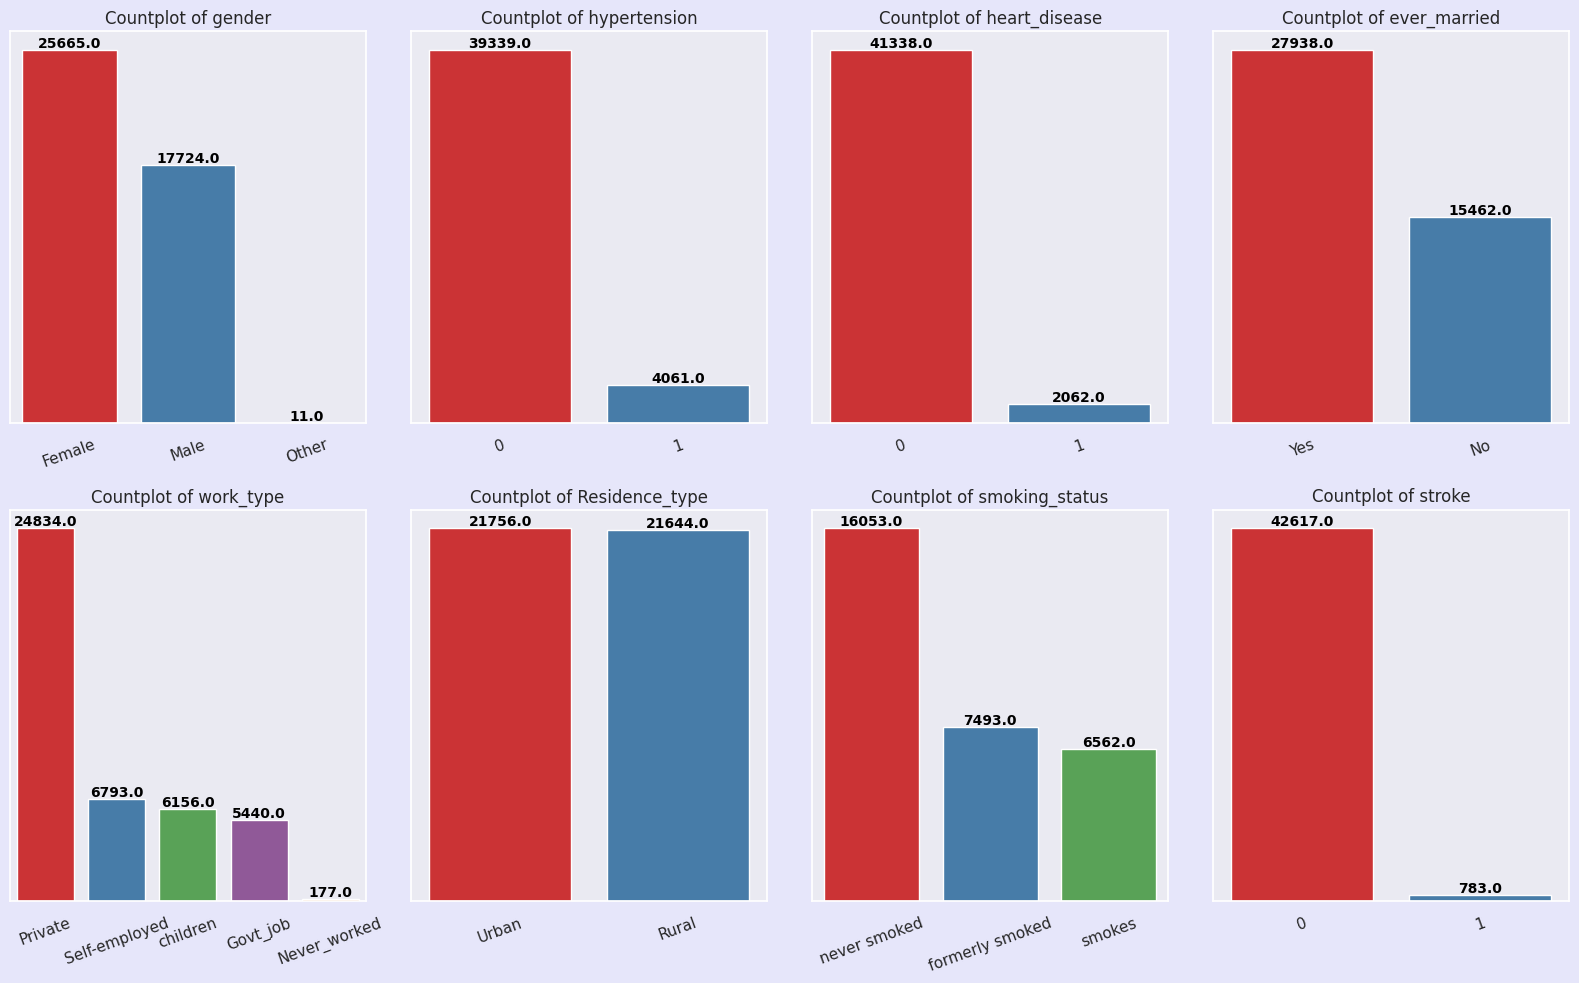

In [26]:
# Plot countplots for categorical features
# Set categorical features
categorical_features = ['gender', 'hypertension', 'heart_disease','ever_married',
                        'work_type', 'Residence_type', 'smoking_status', 'stroke']

# Plot countplots
plt.figure(figsize=(16, 10), facecolor='lavender')
for i, feature in enumerate(categorical_features, 1):
    ax = plt.subplot(2, 4, i)
    plot = sns.countplot(data=df_stroke, x=feature, palette='Set1',
                         order=df_stroke[feature].value_counts().index, ax=ax)

    # Set title and labels
    ax.set_title(f'Countplot of {feature}')
    plt.xlabel('')
    plt.ylabel('')
    ax.set_yticks([])
    ax.tick_params(axis='x', rotation=20)

    # Add value labels on top of each bar
    for p in ax.patches:
        ax.annotate(f'{p.get_height()}',
                    (p.get_x() + p.get_width() / 2, p.get_height()),
                    ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

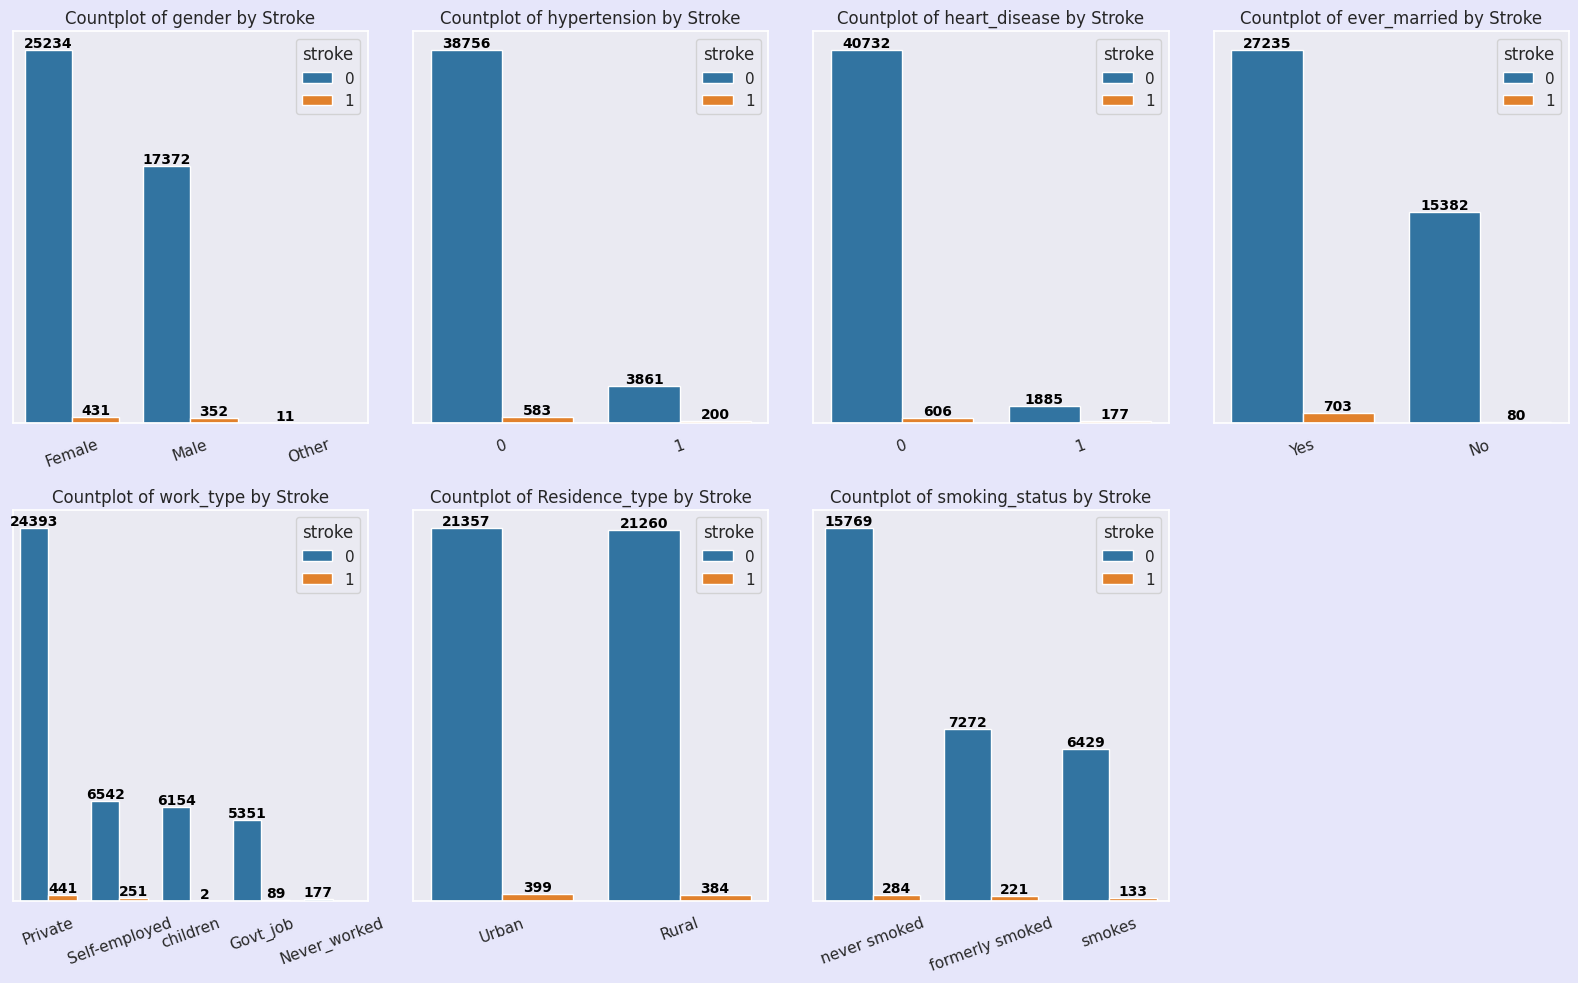

In [27]:
# Plot countplots for categorical features with hue='stroke'
# Set categorical features
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                        'work_type', 'Residence_type', 'smoking_status']

# Plot countplots with hue='stroke'
plt.figure(figsize=(16, 10), facecolor='lavender')
for i, feature in enumerate(categorical_features, 1):
    ax = plt.subplot(2, 4, i)
    plot = sns.countplot(data=df_stroke, x=feature, hue='stroke',               # Color by 'stroke'
                         palette='tab10', order=df_stroke[feature].value_counts().index, ax=ax)

    # Set title and labels
    ax.set_title(f'Countplot of {feature} by Stroke')
    plt.xlabel('')
    plt.ylabel('')
    ax.set_yticks([])
    ax.tick_params(axis='x', rotation=20)

    # Add value labels for hue
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{int(height)}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

In [28]:
# Filter baris dengan gender 'Other'
other_gender_data = df_stroke[df_stroke['gender'] == 'Other']

# Tampilkan tabel
print(f"Number of data with gender 'Other': {len(other_gender_data)}")
display(other_gender_data)

Number of data with gender 'Other': 11


id gender   age  hypertension  heart_disease ever_married work_type  \
2914   56156  Other  26.0             0              0           No   Private   
10768  26188  Other  46.0             0              0           No   Private   
15620  52984  Other  27.0             0              0           No   Private   
15838  24893  Other  53.0             0              0          Yes   Private   
19748  13471  Other  39.0             0              0          Yes  Govt_job   
21041  31015  Other  19.0             0              0           No   Private   
21192  27043  Other  49.0             0              0          Yes   Private   
24252  51111  Other  51.0             0              0          Yes   Private   
26199  42452  Other  10.0             0              0           No  children   
26831  49812  Other  53.0             0              0          Yes  Govt_job   
40768  14986  Other  11.0             0              0           No  children   

      Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
2914           Rural             143.33  22.4  formerly smoked       0  
10768          Rural              83.28   NaN     never smoked       0  
15620          Urban              62.45   NaN           smokes       0  
15838          Rural              89.65   NaN              NaN       0  
19748          Urban              95.59  32.0  formerly smoked       0  
21041          Rural              75.76  32.2  formerly smoked       0  
21192          Urban              94.88  37.2     never smoked       0  
24252          Rural              91.75  32.2  formerly smoked       0  
26199          Rural              72.05  21.2  formerly smoked       0  
26831          Urban              65.29   NaN              NaN       0  
40768          Urban             101.30  18.1  formerly smoked       0

In [29]:
stroke_summary = other_gender_data['stroke'].value_counts().rename(index={0: 'No Stroke', 1: 'Stroke'})
print("Stroke distribution for gender 'Other':")
print(stroke_summary)

Stroke distribution for gender 'Other':
stroke
No Stroke    11
Name: count, dtype: int64


In [30]:
# Filter baris dengan work_type 'Never_worked'
never_worked_data = df_stroke[df_stroke['work_type'] == 'Never_worked']

# Tampilkan jumlah datanya
print(f"Number of data with work_type 'Never_worked': {len(never_worked_data)}")

# Tampilkan tabel data
display(never_worked_data)

Number of data with work_type 'Never_worked': 177


id  gender   age  hypertension  heart_disease ever_married  \
4      46136    Male  14.0             0              0           No   
362    61408    Male  23.0             0              0           No   
650    13948  Female  19.0             0              0           No   
703    16556    Male  13.0             0              0           No   
723    56986    Male  17.0             0              0           No   
...      ...     ...   ...           ...            ...          ...   
41711  13544  Female  14.0             0              0           No   
41953  68997    Male  29.0             0              0          Yes   
42314  70476  Female  17.0             0              0           No   
42830  60898  Female  30.0             0              0           No   
43216  46229  Female  20.0             0              0           No   

          work_type Residence_type  avg_glucose_level   bmi smoking_status  \
4      Never_worked          Rural             161.28  19.1            NaN   
362    Never_worked          Urban             125.26  18.7   never smoked   
650    Never_worked          Urban              86.96  25.8   never smoked   
703    Never_worked          Rural             111.48  20.8            NaN   
723    Never_worked          Urban             113.25  23.4   never smoked   
...             ...            ...                ...   ...            ...   
41711  Never_worked          Urban              93.53  20.7            NaN   
41953  Never_worked          Rural             158.02  24.1         smokes   
42314  Never_worked          Urban              88.90  19.8   never smoked   
42830  Never_worked          Urban              91.80  25.5   never smoked   
43216  Never_worked          Urban              82.37  33.5   never smoked   

       stroke  
4           0  
362         0  
650         0  
703         0  
723         0  
...       ...  
41711       0  
41953       0  
42314       0  
42830       0  
43216       0  

[177 rows x 12 columns]

In [31]:
stroke_summary_never_worked = never_worked_data['stroke'].value_counts().rename(index={0: 'No Stroke', 1: 'Stroke'})
print("Stroke distribution for work_type 'Never_worked':")
print(stroke_summary_never_worked)

Stroke distribution for work_type 'Never_worked':
stroke
No Stroke    177
Name: count, dtype: int64


<hr>
<div id="bivariate_analysis">
    <h2>Bivariate Analysis</h2>    
</div>
<div>
    <ol>
        <li><a href="#numerical_features">BA for Numerical Features</a></li>
        <li><a href="#categorical_features">BA for Categorical Features</a></li>                
    </ol>
</div>
<br>

<div id="numerical_features">
    <h2>BA for Numerical Features</h2>    
</div>

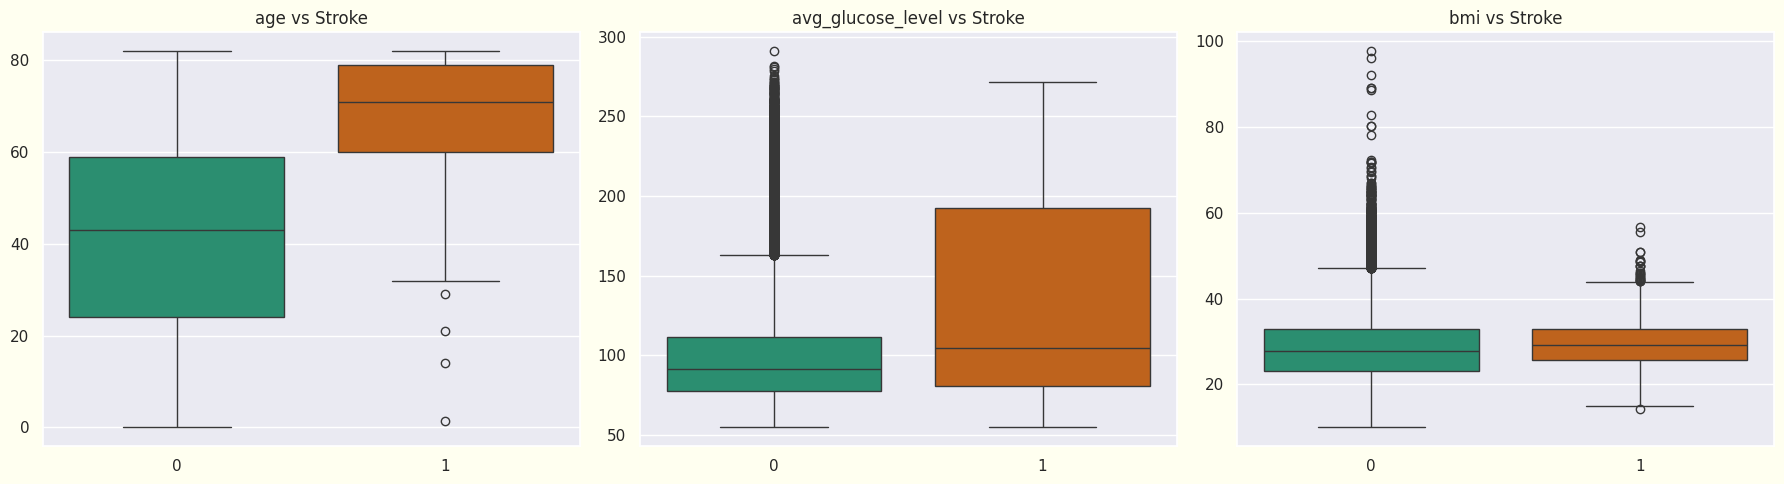

In [32]:
# Plot boxplots for numerical features vs 'stroke'
# Set numerical features
numerical_features = ['age', 'avg_glucose_level', 'bmi']

# Plot boxplots
plt.figure(figsize=(18, 5), facecolor='ivory')
for i, feature in enumerate(numerical_features, 1):
    ax = plt.subplot(1, 3, i)
    sns.boxplot(data=df_stroke, x='stroke', y=feature, palette='Dark2', ax=ax)

    # Set title and labels
    ax.set_title(f'{feature} vs Stroke')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

<div id="categorical_features">
    <h2>BA for Categorical Features</h2>    
</div>

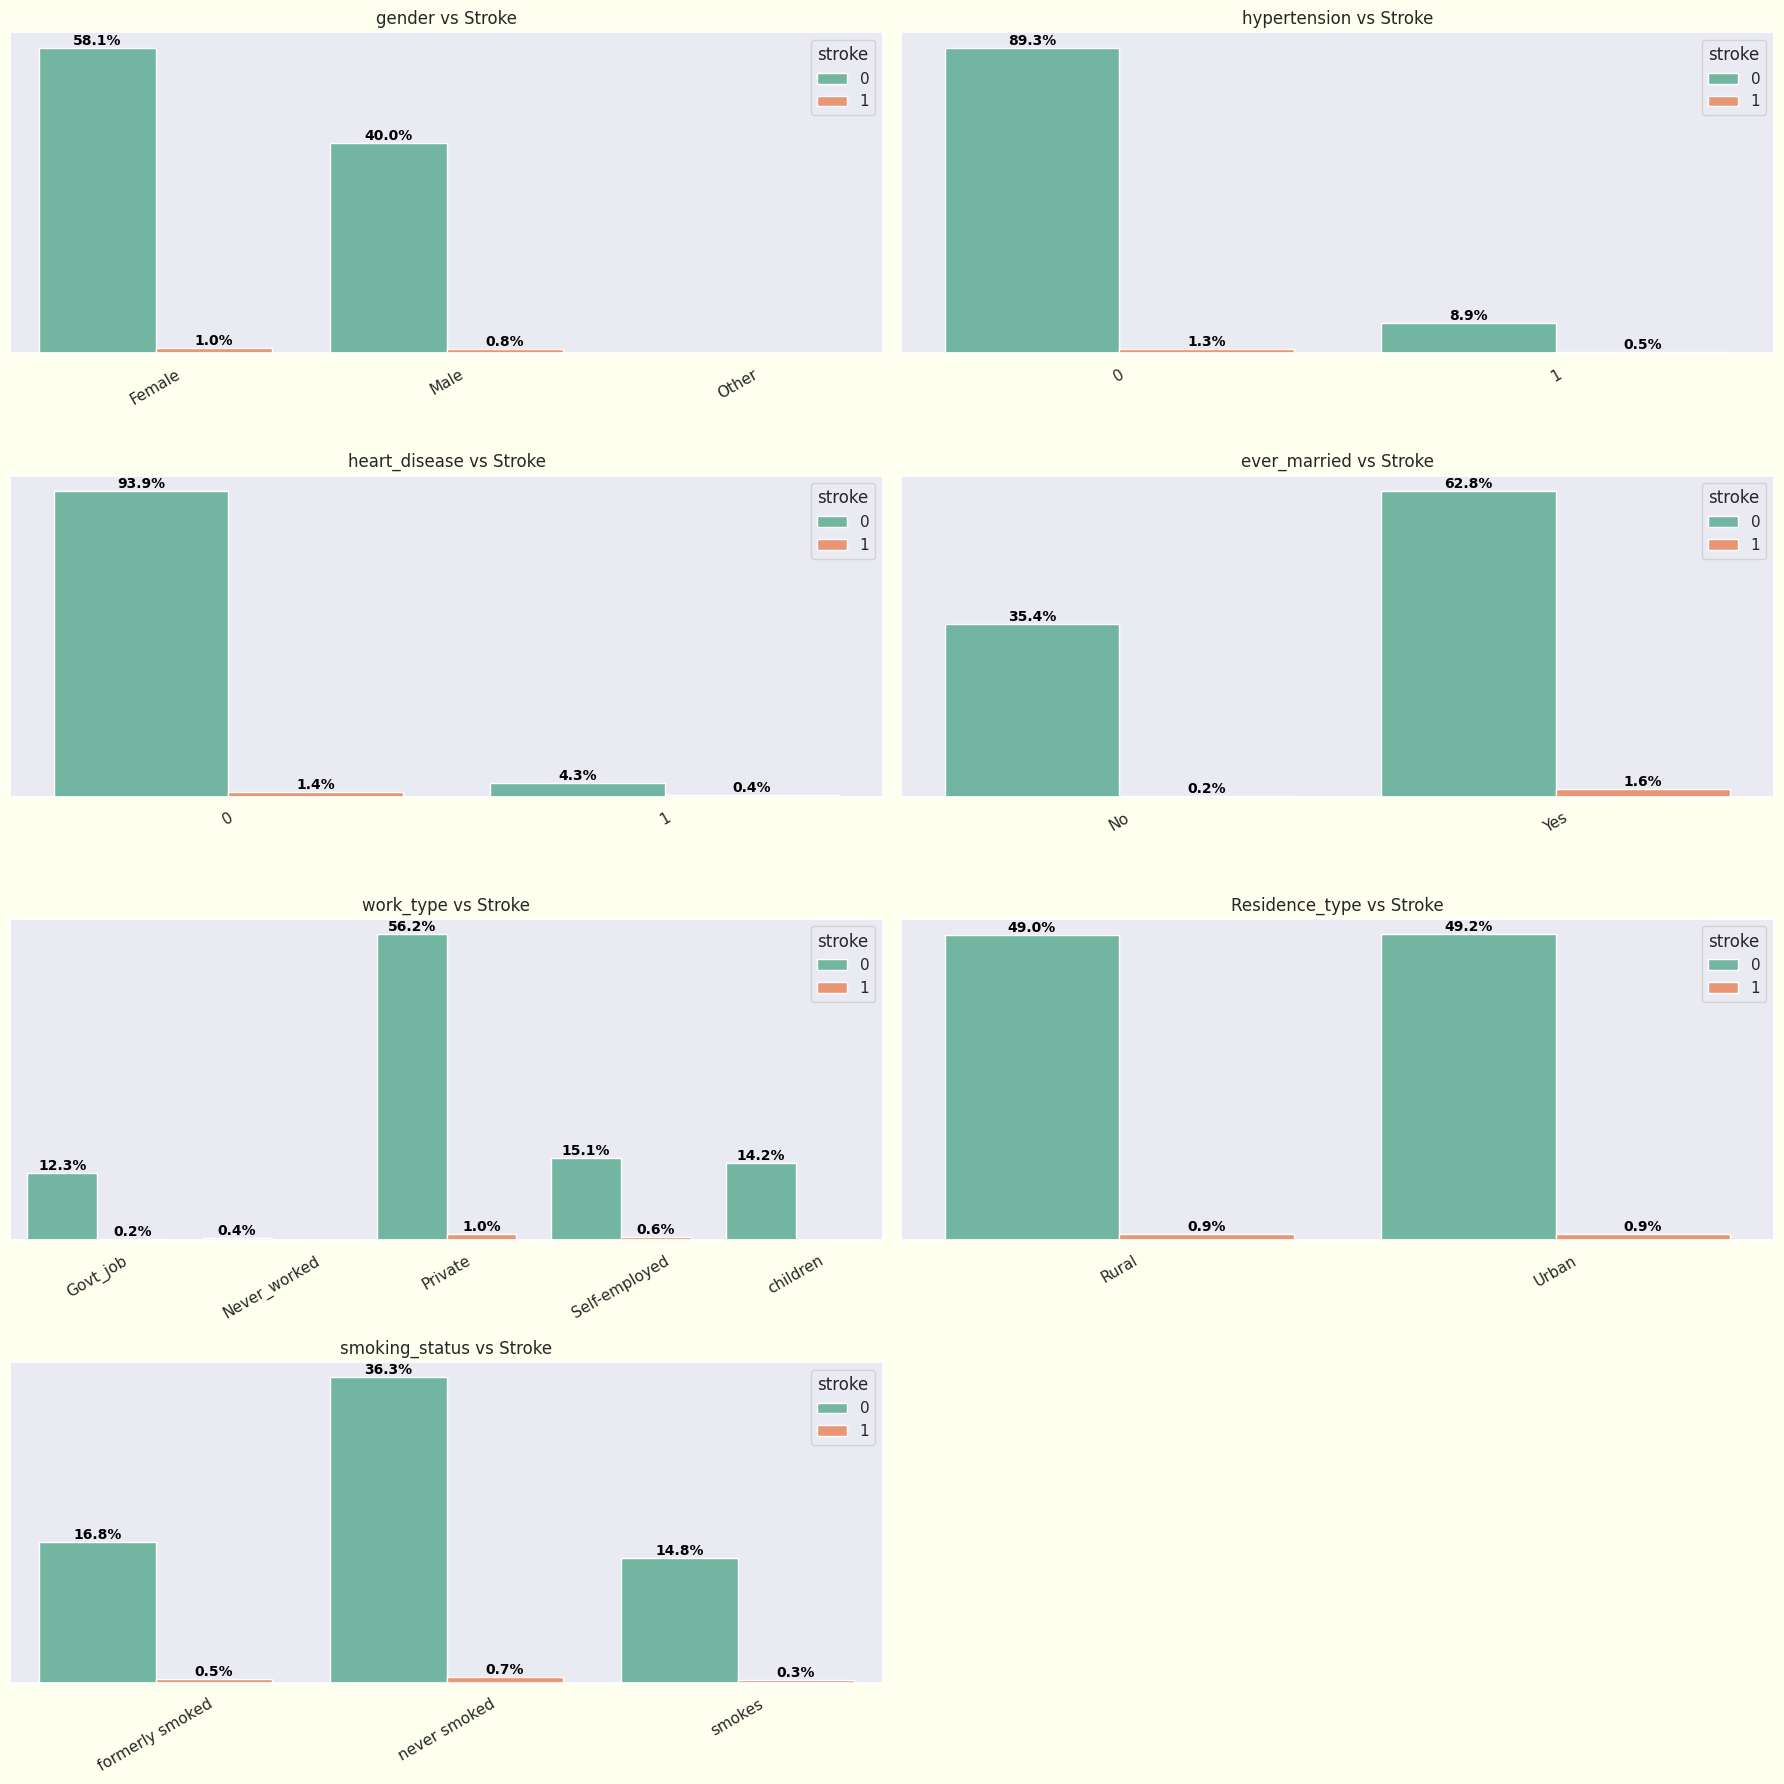

In [33]:
# Plot barplots for categorical features vs 'stroke'
# Set categorical features
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married',
                        'work_type', 'Residence_type', 'smoking_status']

# Set figure
plt.figure(figsize=(18, 18), facecolor='ivory')
for i, feature in enumerate(categorical_features, 1):
    ax = plt.subplot(4, 2, i)

    # Group by feature and stroke, then count
    count_df = df_stroke.groupby([feature, 'stroke']).size().reset_index(name='count')

    # Calculate percent of total dataset
    total_count = len(df_stroke)
    count_df['percentage'] = (count_df['count'] / total_count * 100).round(1)

    # Plot barplots
    sns.barplot(data=count_df, x=feature, y='percentage', hue='stroke', palette='Set2', ax=ax)     # Color by 'stroke'
    ax.set_title(f'{feature} vs Stroke')
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.tick_params(axis='x', rotation=30)
    ax.set_yticks([])

    # Add percentage labels on top
    for p in ax.patches:
        height = p.get_height()
        if height > 0:
            ax.annotate(f'{height:.1f}%',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.tight_layout()
plt.show()

<hr>
<div id="correlation_analysis">
    <h2>Correlation Analysis</h2>    
</div>

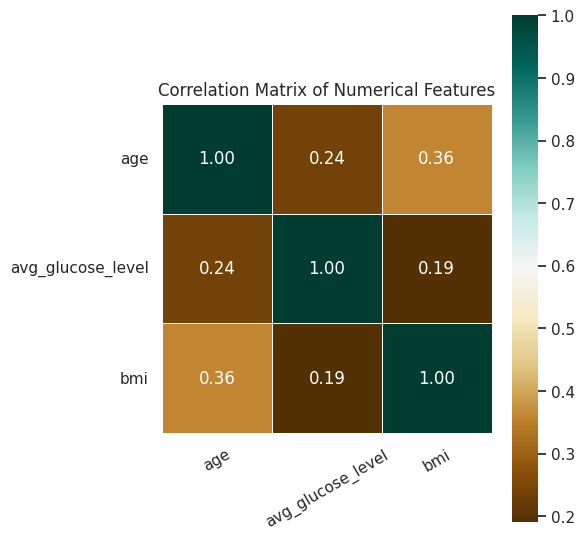

In [34]:
# Plot a heatmap to explore relationships between numeric variables
# Select numerical features
numerical_features = ['age', 'avg_glucose_level', 'bmi']

# Compute the correlation matrix
corr_matrix = df_stroke[numerical_features].corr()

# Plot the heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(corr_matrix,
            annot=True,         # Show correlation coefficients
            cmap='BrBG',
            fmt=".2f",          # Format for values
            linewidths=0.5,
            square=True)

# Set title and adjust layout
plt.title('Correlation Matrix of Numerical Features')
plt.xticks(rotation=30)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

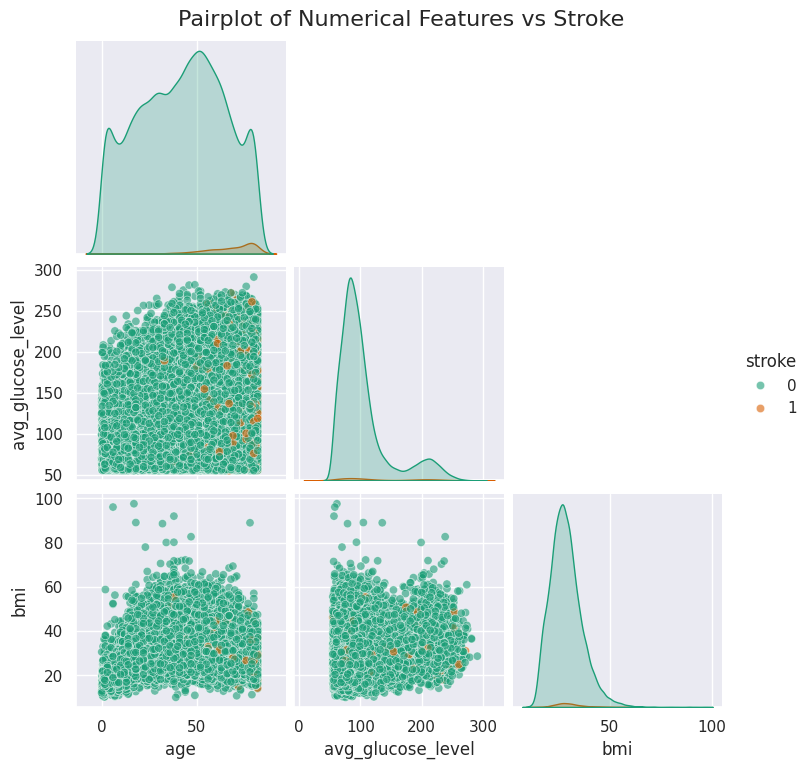

In [35]:
# Create pairplot to explore pairwise relationships
# Select numerical features including 'stroke'
pairplot_features = ['age', 'avg_glucose_level', 'bmi', 'stroke']

# Plot the pairplot
sns.pairplot(df_stroke[pairplot_features],
             hue='stroke',             # Color by 'stroke'
             palette='Dark2',
             corner=True,              # Plot only lower triangle
             plot_kws={'alpha': 0.6})  # Transparency for points

# Set title
plt.suptitle('Pairplot of Numerical Features vs Stroke', fontsize=16, y=1.02)
plt.show()

We now study how the feature variables are correlated with the targe ('stroke') in this dataset.

In [36]:
health_stroke_cat_numeric_df = df_stroke.copy()
health_stroke_cat_numeric_df.drop(columns=['id'], inplace=True)

# convert the categorical variables to categorical type
# (for efficient reason)
cat_col = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
health_stroke_cat_numeric_df[cat_col] = health_stroke_cat_numeric_df[cat_col].astype('category')
health_stroke_cat_numeric_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43400 entries, 0 to 43399
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   gender             43400 non-null  category
 1   age                43400 non-null  float64 
 2   hypertension       43400 non-null  int64   
 3   heart_disease      43400 non-null  int64   
 4   ever_married       43400 non-null  category
 5   work_type          43400 non-null  category
 6   Residence_type     43400 non-null  category
 7   avg_glucose_level  43400 non-null  float64 
 8   bmi                41938 non-null  float64 
 9   smoking_status     30108 non-null  category
 10  stroke             43400 non-null  int64   
dtypes: category(5), float64(3), int64(3)
memory usage: 2.2 MB


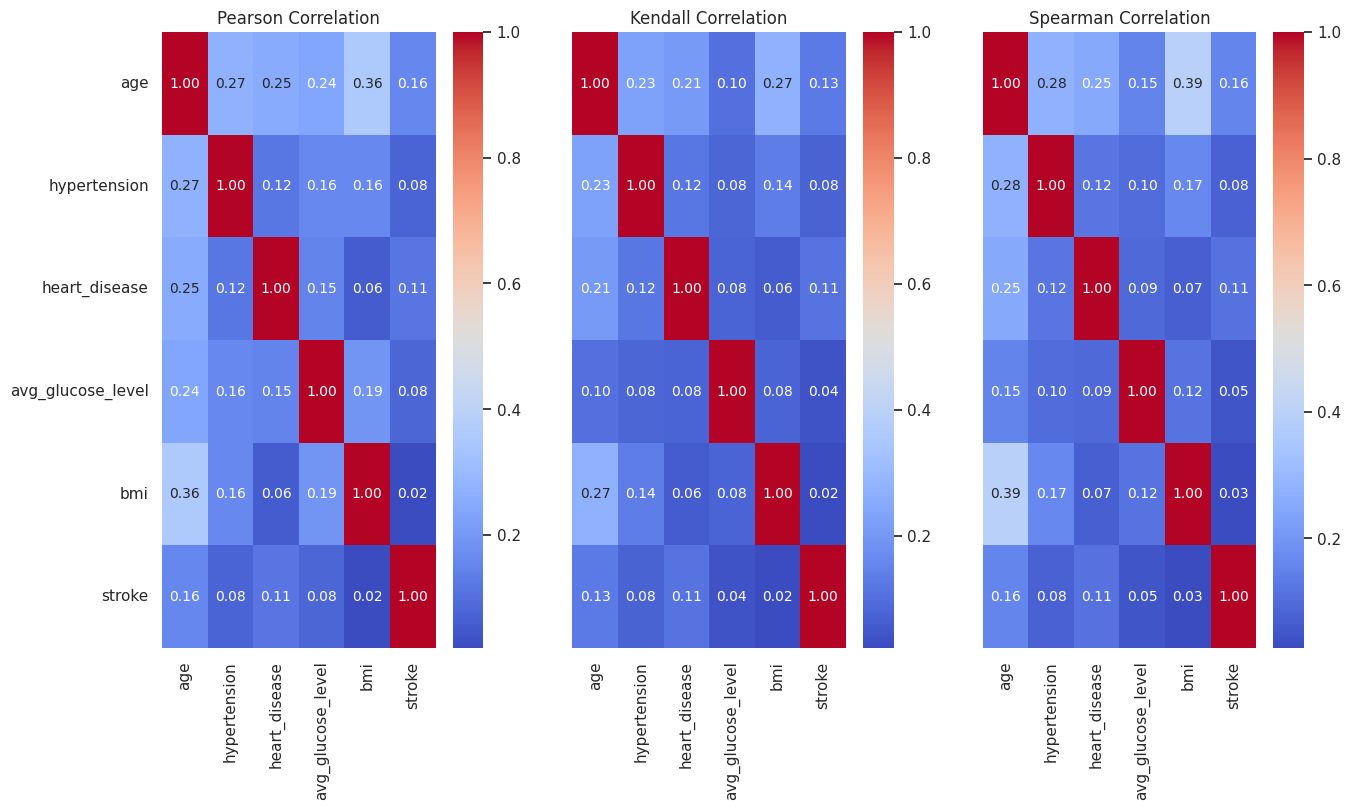

In [37]:
corr_type = ['pearson', 'kendall', 'spearman']
fig, ax = plt.subplots(ncols=3, sharey=True, figsize =(15,8) )
i=0

# correlation heatmap for numeric variables only
for corr in corr_type:
    df_corr = health_stroke_cat_numeric_df.select_dtypes(include=['number']).corr(method=corr)
    sns.heatmap(df_corr, annot=True, annot_kws={"size": 10}, ax=ax[i], cmap="coolwarm", fmt=".2f")
    ax[i].set_title(f'{corr.capitalize()} Correlation')
    i += 1


From the heatmap, we can see the features [age, heart_disease] are the two most correlated numeric variables with the target ('stroke'), whereas [hypertension, avg_glucose_level] are next and [bmi] has the least correlation. This is true for all three correlation coefficients tested.

Ranked by correlation coefficient, we have [age > heart_disease > hypertension > avg_glucose_level > bmi] (for pearson's r)

#### - correlation, categorical variable

Next we compute the correlation coefficients for categorical variables. To do so, we would need to perform the label encoding preprocessing step, i.e. converting categorical variables into numeric form (using LabelEncoder/custom mapping for ordinal; OneHotEncoder/pd.get_dummies for nominal).

This preprocessing step is also necessary for training certain ML models.

In [38]:
# Creating a copy of the health stroke dataframe and imputing the missing values
# in ['bmi', 'smoking_status'] for calculating the correlation coefficient
# (Imputation methods will be explained in more detail in the next section)
health_stroke_df2 = df_stroke.copy()

# using median for impute bmi missing
health_stroke_df2.bmi.fillna(health_stroke_df2.bmi.median(), inplace=True)
# using a new label 'no_info' for impute smoking_status missing
health_stroke_df2.smoking_status.fillna('no info', inplace=True)

In [39]:
# Encode nominal features
nom_col = ['gender', 'ever_married', 'work_type', 'Residence_type']
health_stroke_df2 = pd.get_dummies(health_stroke_df2, columns=nom_col)

# Encode ordinal feature: smoking_status
smoke_mapper = {'never smoked': 0, 'no info': 1, 'formerly smoked': 2, 'smokes': 3}
health_stroke_df2['smoking_status_code'] = health_stroke_df2['smoking_status'].map(smoke_mapper)


Correlation heatmap between the (categorical) features and target ('stroke') variables

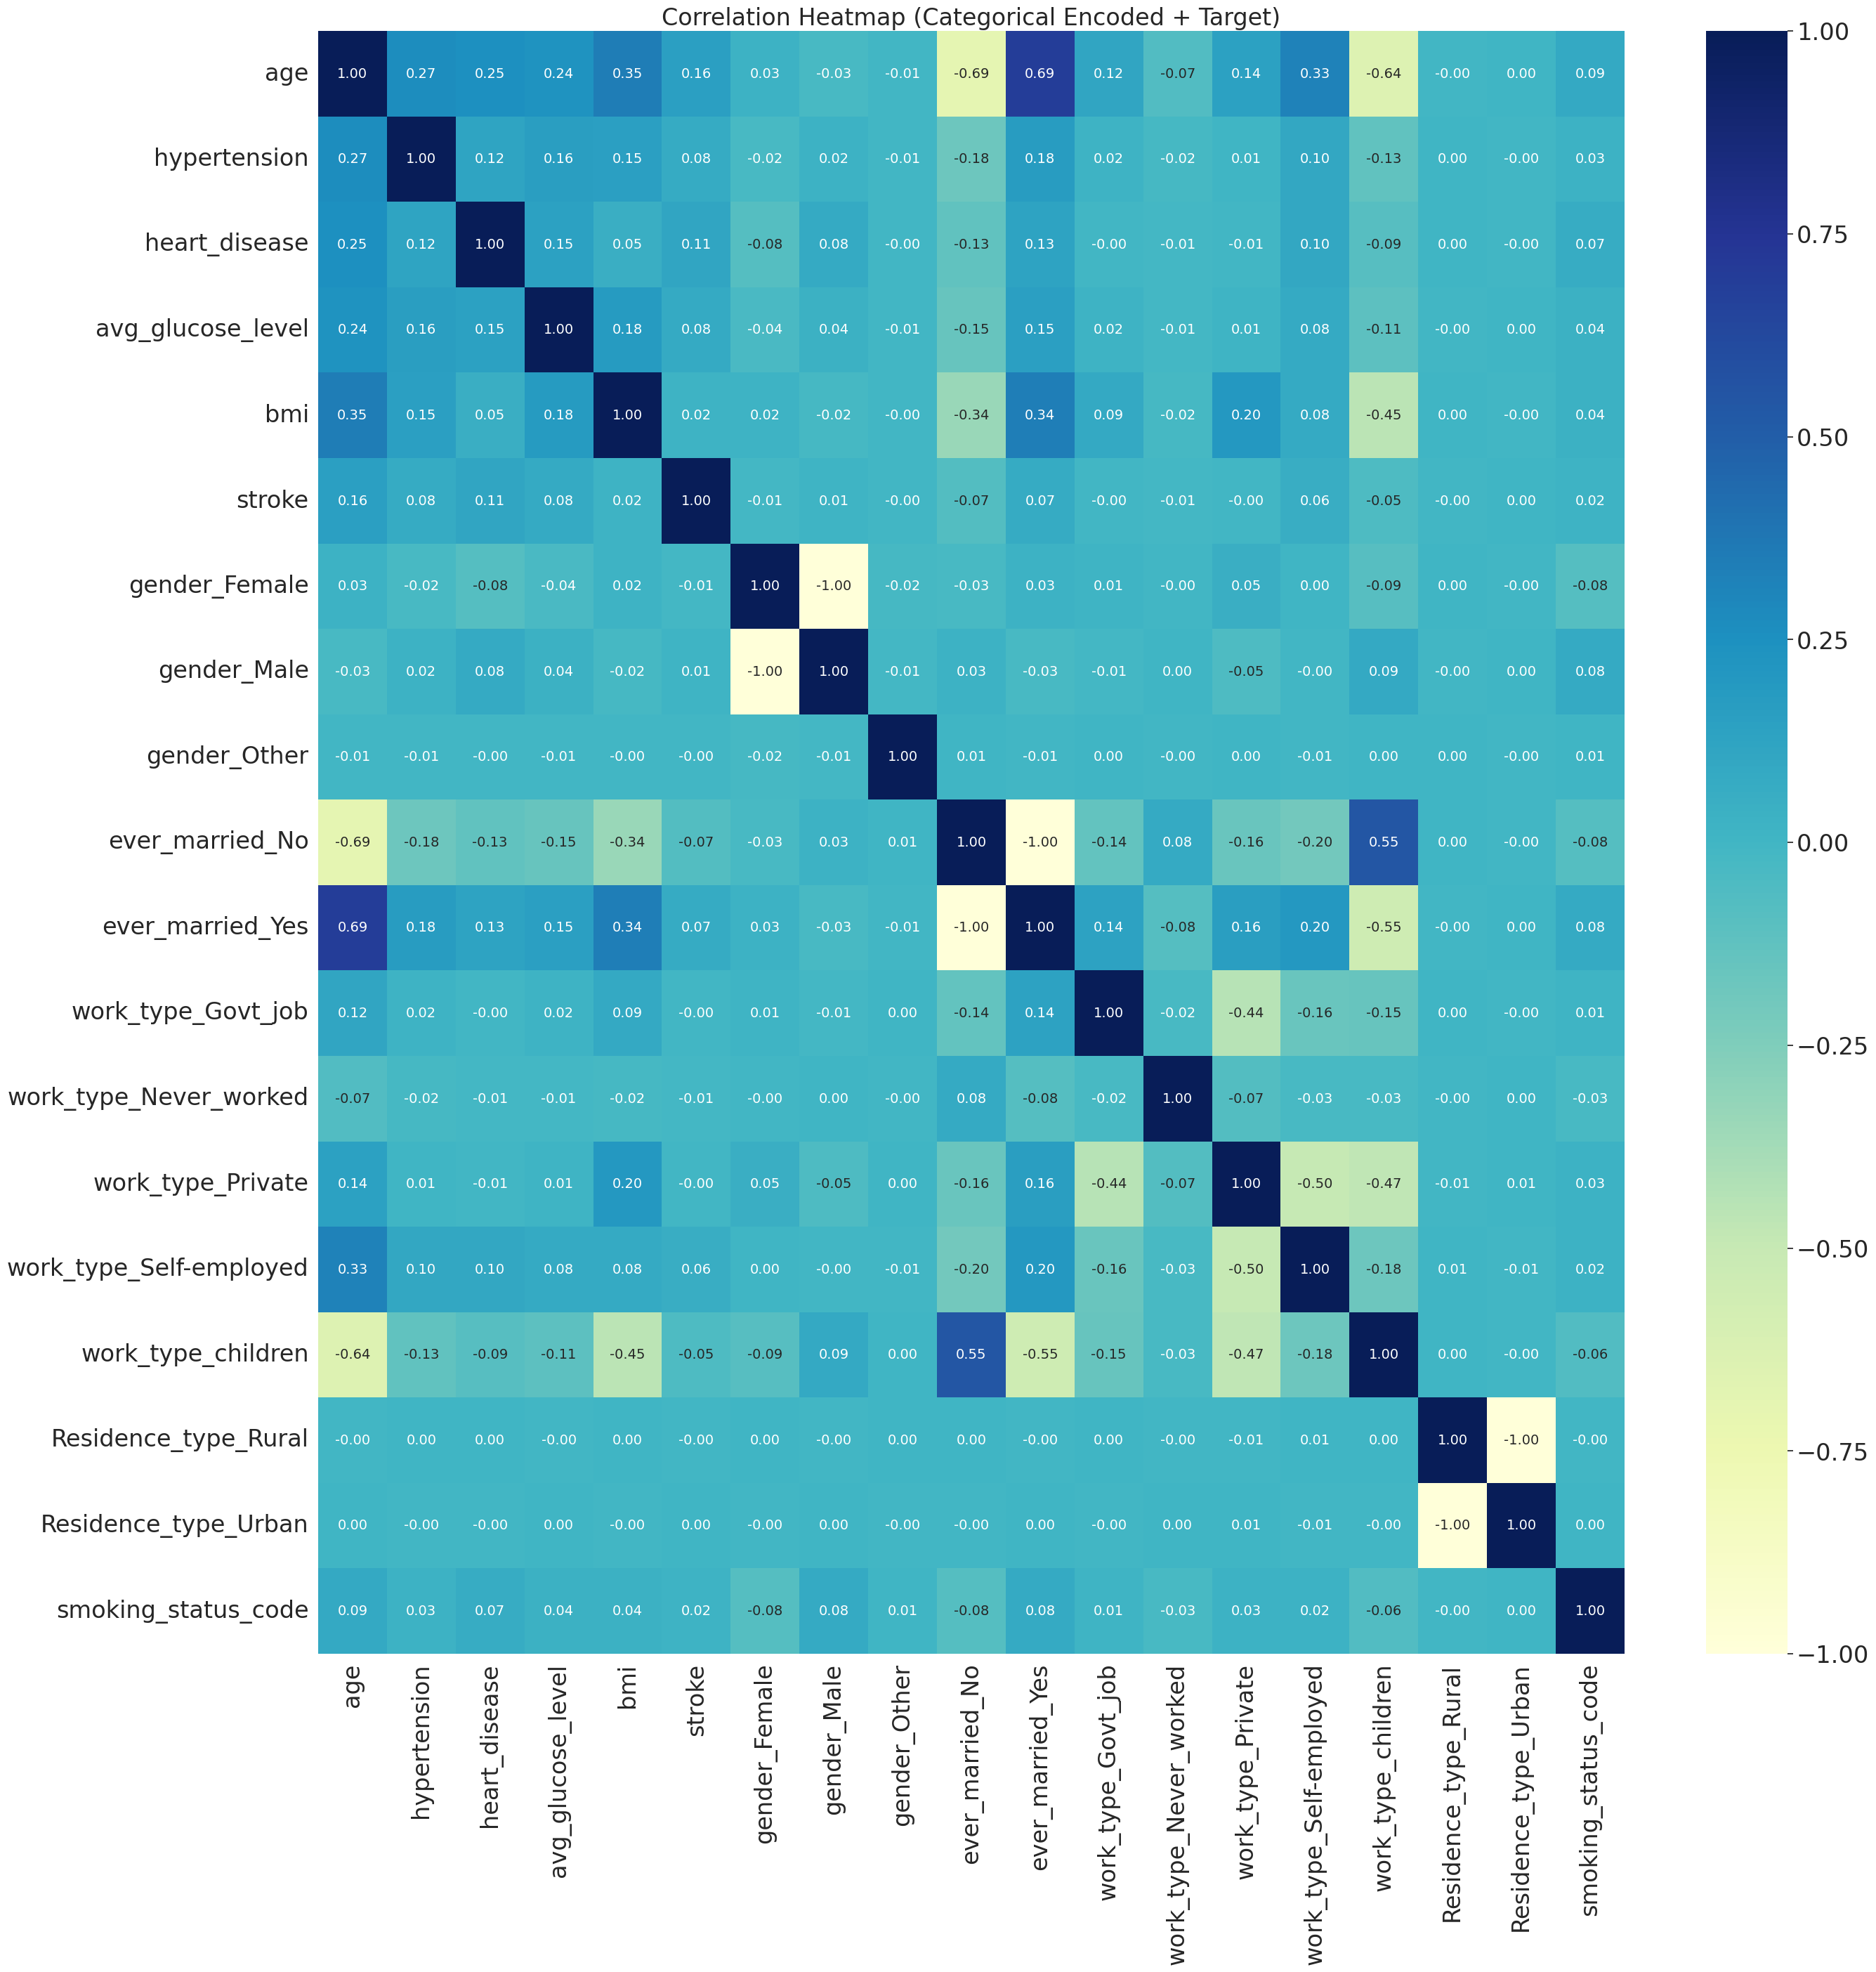

In [40]:
# Drop unnecessary columns
pearson_corr_full = health_stroke_df2.drop(columns=['id', 'smoking_status']).corr()

# Plot
sns.set(font_scale=2.2)
plt.figure(figsize=(30, 30))
sns.heatmap(pearson_corr_full, annot=True, annot_kws={"size": 14}, cmap="YlGnBu", fmt=".2f")
plt.title("Correlation Heatmap (Categorical Encoded + Target)", fontsize=24)
plt.show()

From this second heatmap, we can see the categorical features [gender, Residence_type] have very low correlation coefficients with the target ('stroke') i.e. abs<0.012, confirming pervious observations using the corresponding barplots.

ever_married and various classes (i.e. children, Self-employed) within categorical features [work_type] have relatively high correlation coefficients with the target ('stroke') i.e. abs>0.05, again confirming pervious observations using the corresponding barplots.

Again, surprisingly, smoking_status do not seem to have a significant correlation (i.e. ~0.02) with patients having strokes or not.

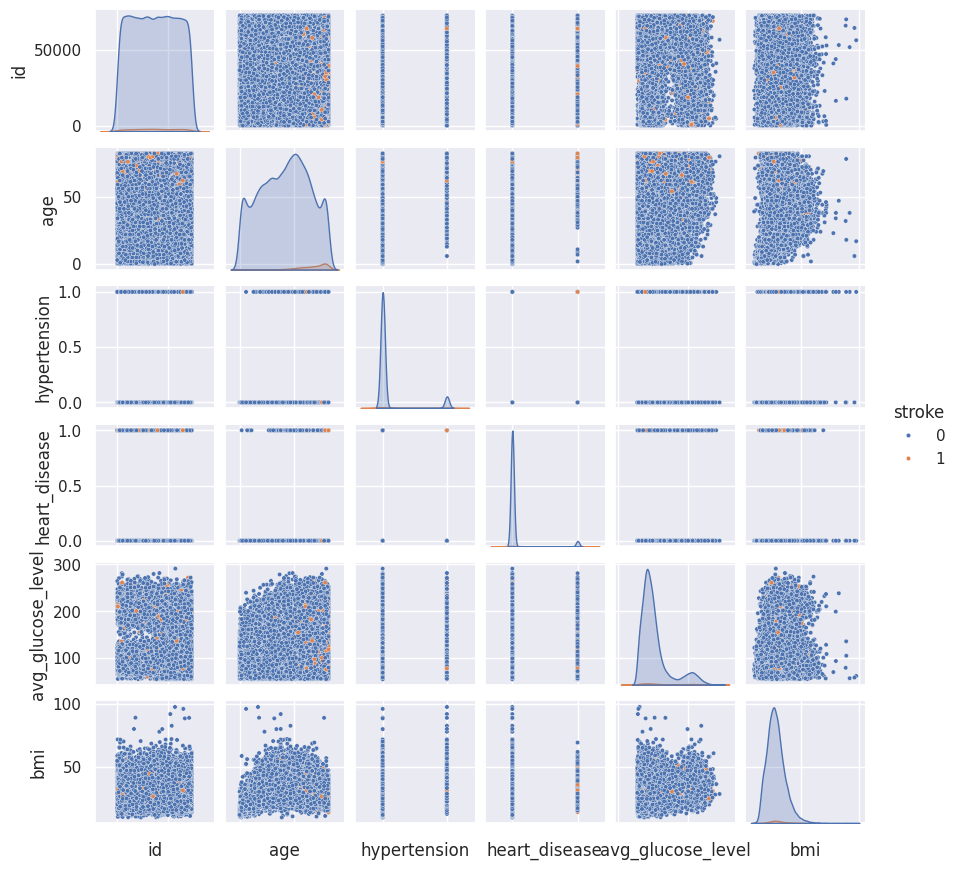

In [41]:
%matplotlib inline
sns.set()

# pair plots of entire dataset (for reference only)
pair_plot = sns.pairplot(df_stroke, hue='stroke', palette='deep', size=1.5,
                         diag_kind='kde', diag_kws=dict(shade=True), plot_kws=dict(s=10))
pair_plot.set(xticklabels=[])

<hr>
<div id="detect_outliers">
    <h2>Detect Outliers</h2>    
</div>
<div>
    <ol>
        <li><a href="#boxplot">Boxplot</a></li>
        <li><a href="#iqr">IQR</a></li>
        <li><a href="#dbscan">DBSCAN</a></li>
        <li><a href="#iqr_dbscan">Identify Common Outliers between IQR and DBSCAN</a></li>               
    </ol>
</div>
<br>

<div id="boxplot">
    <h2>Boxplot</h2>    
</div>

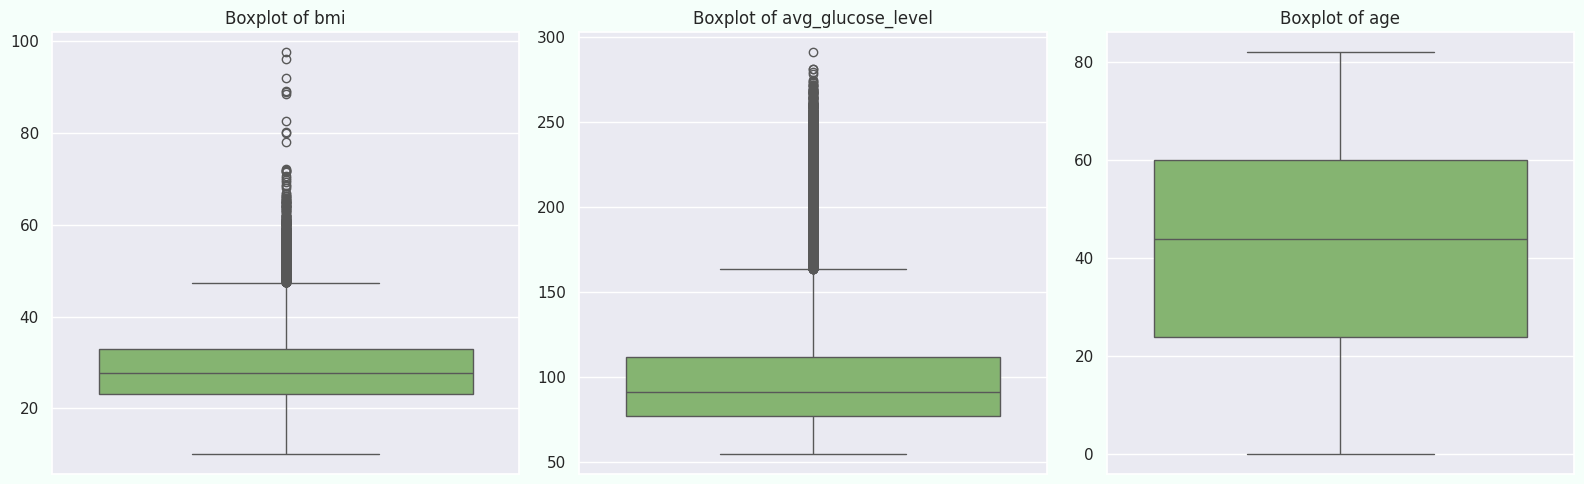

In [42]:
# Plot a boxplot to detect outliers in numerical features
# Define numerical features to analyze
numerical_features = ['bmi', 'avg_glucose_level', 'age']

# Set up the figure
plt.figure(figsize=(16, 5), facecolor='mintcream')
for i, feature in enumerate(numerical_features, 1):
    ax = plt.subplot(1, 3, i)

    # Create boxplot
    sns.boxplot(data=df_stroke, y=feature, ax=ax, palette='summer')
    ax.set_title(f'Boxplot of {feature}')
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.tight_layout()
plt.show()

<div id="iqr">
    <h2>IQR</h2>    
</div>

In [43]:
# Detect univariate outliers using IQR for each numerical feature
# Iterate through each numerical feature in the list
for feature in numerical_features:
    # Calculate the first quartile (25th percentile) of the feature
    Q1 = df_stroke[feature].quantile(0.25)
    # Calculate the third quartile (75th percentile) of the feature
    Q3 = df_stroke[feature].quantile(0.75)

    # Compute the Interquartile Range (IQR) as the difference between Q3 and Q1
    IQR = Q3 - Q1

    # Determine the lower bound for identifying outliers
    lower_bound = Q1 - 1.5 * IQR
    # Determine the upper bound for identifying outliers
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers that fall below the lower bound or above the upper bound
    outliers = df_stroke[(df_stroke[feature] < lower_bound) | (df_stroke[feature] > upper_bound)]

    # Print the number of outliers detected for the current feature
    print(f"\n{feature}: {len(outliers)} outliers detected\n")


bmi: 888 outliers detected


avg_glucose_level: 4978 outliers detected


age: 0 outliers detected



<div id="dbscan">
    <h2>DBSCAN</h2>    
</div>

In [44]:
# Detect multivariate outliers using DBSCAN for numerical features
# Select numerical features for DBSCAN
features_for_dbscan = df_stroke[['age', 'avg_glucose_level', 'bmi']].copy()

# Handle potential missing values
features_for_dbscan.dropna(inplace=True)

# Scale features usind Standard Scaler
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_for_dbscan)

In [45]:
# Apply DBSCAN
db = DBSCAN(eps=1.2, min_samples=15).fit(features_scaled)

# Add labels to the DataFrame
features_for_dbscan['DBSCAN_label'] = db.labels_

# Create a new column 'dbscan_outlier' in the DataFrame to flag points identified as outliers by DBSCAN
# Outliers are labeled with -1 in the 'DBSCAN_label' column
features_for_dbscan['dbscan_outlier'] = features_for_dbscan['DBSCAN_label'] == -1

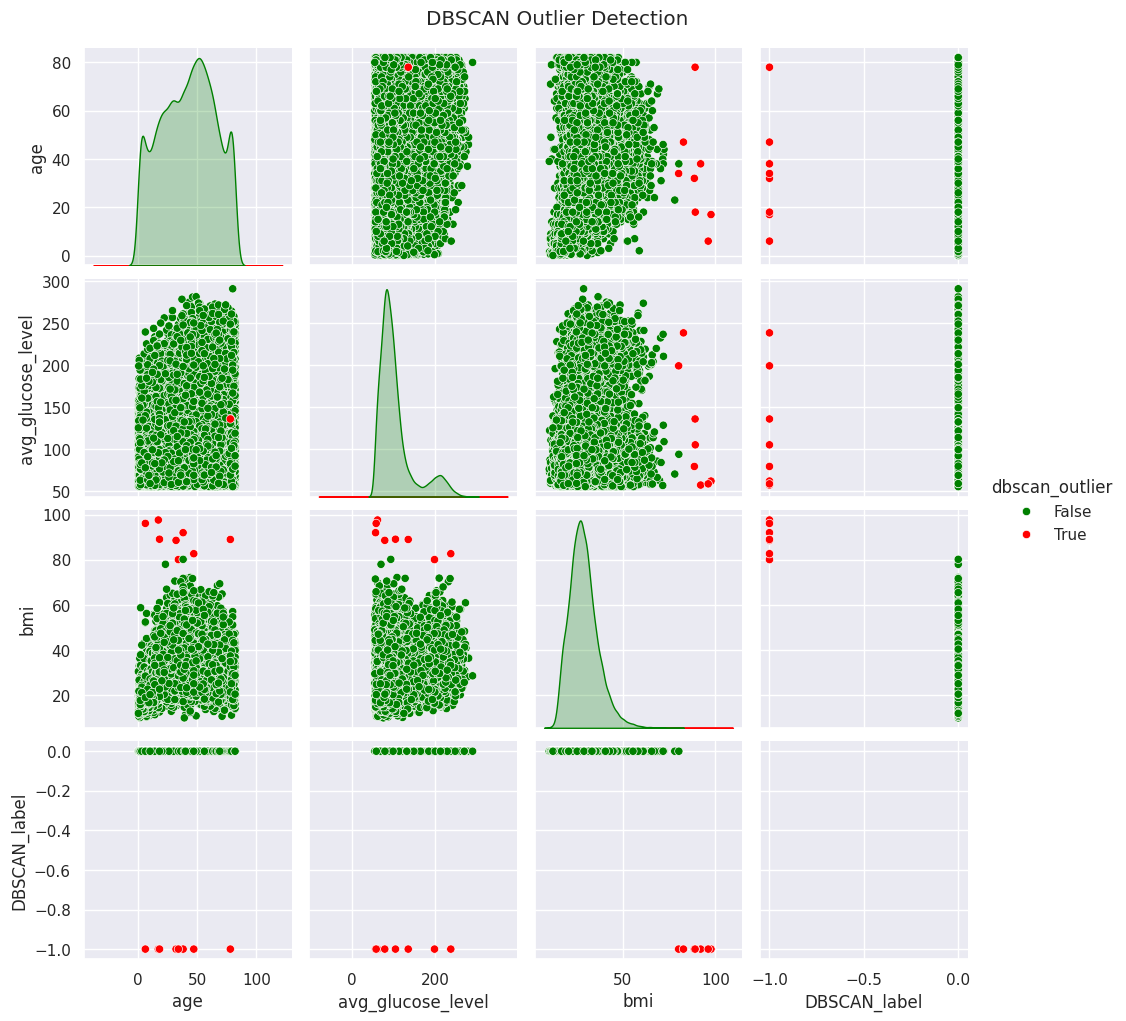

In [46]:
# Create a pairplot to visualize the relationships between features in the DataFrame
# The hue parameter is set to the 'dbscan_outlier' column to color points based on whether they are outliers
# Red represents outliers (True) and green represents inliers (False)
sns.pairplot(features_for_dbscan, hue='dbscan_outlier', palette={True: 'red', False: 'green'})
plt.suptitle('DBSCAN Outlier Detection', y=1.02)
plt.show()

In [47]:
# Count the total number of outliers by summing the values in the 'dbscan_outlier' column
# Since True is treated as 1 and False as 0, this effectively counts how many outliers were detected
dbscan_outliers = sum(features_for_dbscan['dbscan_outlier'])

# Print the total number of outliers detected by DBSCAN
print(f"\nNumber of outliers detected by DBSCAN: {dbscan_outliers}")


Number of outliers detected by DBSCAN: 8


<div id="iqr_dbscan">
    <h2>Identify Common Outliers between IQR and DBSCAN</h2>    
</div>

In [48]:
# Identify common outliers between IQR and DBSCAN
# Create a copy of the original DataFrame with selected numerical features
df_outlier_check = df_stroke[['age', 'avg_glucose_level', 'bmi']].copy()

# Detect univariate outliers using IQR for all 3 features and create a boolean mask
iqr_mask = pd.Series(False, index=df_outlier_check.index)

# Iterate through each numerical feature in the list
for feature in ['age', 'avg_glucose_level', 'bmi']:
    Q1 = df_outlier_check[feature].quantile(0.25)     # Calculate the first quartile
    Q3 = df_outlier_check[feature].quantile(0.75)     # Calculate the third quartile
    IQR = Q3 - Q1                    # Compute the Interquartile Range (IQR)
    lower_bound = Q1 - 1.5 * IQR     # Determine the lower bound for identifying outliers
    upper_bound = Q3 + 1.5 * IQR     # Determine the upper bound for identifying outliers

    # Combine masks using OR to flag all univariate outliers
    iqr_mask |= (df_outlier_check[feature] < lower_bound) | (df_outlier_check[feature] > upper_bound)

# Reindex the IQR mask to match the filtered (non-null) DBSCAN data
iqr_mask_filtered = iqr_mask.loc[features_for_dbscan.index]

In [49]:
# Identify common outliers (True in both IQR and DBSCAN)
common_outlier_mask = iqr_mask_filtered & features_for_dbscan['dbscan_outlier']

# Extract and display common outliers
common_outliers_df = features_for_dbscan[common_outlier_mask]

# Output results
print(f"\nNumber of common outliers detected by both IQR and DBSCAN: {len(common_outliers_df)}\n")
display(common_outliers_df)


Number of common outliers detected by both IQR and DBSCAN: 8



age  avg_glucose_level   bmi  DBSCAN_label  dbscan_outlier
1913   17.0              61.67  97.6            -1            True
4026   38.0              56.90  92.0            -1            True
6340   18.0             104.89  89.1            -1            True
10322   6.0              58.33  96.1            -1            True
25996  32.0              79.09  88.6            -1            True
30650  34.0             199.13  80.1            -1            True
34824  47.0             238.47  82.7            -1            True
43087  78.0             135.73  89.0            -1            True

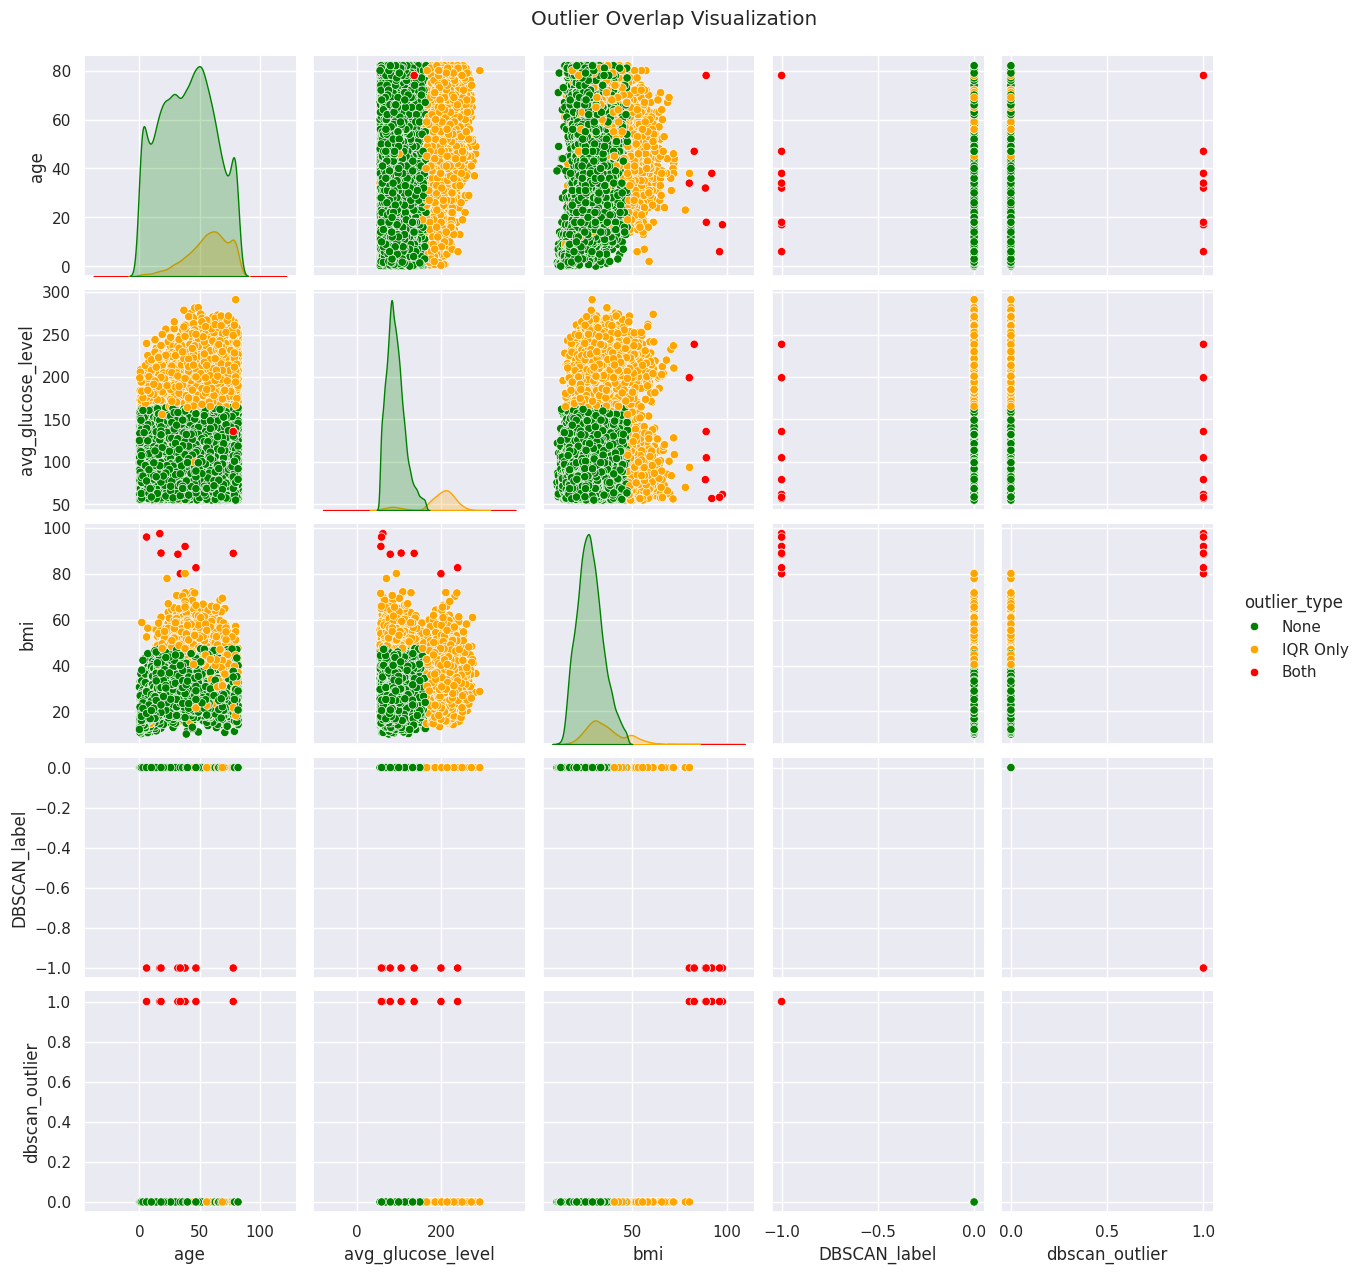

In [50]:
# Create a pairplot with common outliers highlighted
# Create a new column 'outlier_type' and set the default value to 'None' (meaning not an outlier by either method)
features_for_dbscan['outlier_type'] = 'None'

# Label data points detected as outliers only by IQR method
features_for_dbscan.loc[iqr_mask_filtered & ~features_for_dbscan['dbscan_outlier'], 'outlier_type'] = 'IQR Only'

# Label data points detected as outliers only by DBSCAN method
features_for_dbscan.loc[~iqr_mask_filtered & features_for_dbscan['dbscan_outlier'], 'outlier_type'] = 'DBSCAN Only'

# Label data points detected as outliers by both IQR and DBSCAN methods
features_for_dbscan.loc[common_outlier_mask, 'outlier_type'] = 'Both'

# Generate a pairplot to visualize relationships among features and highlight different outlier types
sns.pairplot(
    features_for_dbscan,
    hue='outlier_type',          # Color the points based on outlier type
    palette={
        'None': 'green',         # Normal data
        'IQR Only': 'orange',    # Outliers by IQR only
        'DBSCAN Only': 'blue',   # Outliers by DBSCAN only
        'Both': 'red'            # Outliers by both methods
    }
)

# Set a title
plt.suptitle('Outlier Overlap Visualization', y=1.02)
plt.show()

<hr>
<div id="pre-processing">
    <h2>Pre-processing</h2>    
</div>
<div>
    <ol>
        <li><a href="#convert_data_types">Convert Data Types</a></li>        
        <li><a href="#handle_missing_values">Handle Missing Values</a></li>        
        <li><a href="#remove_outliers">Remove Outliers</a></li>               
        <li><a href="#feature_discretization">Feature Discretization</a></li>  
        <li><a href="#one_hot_encoding">One_hot Encoding</a></li>     
    </ol>
</div>
<br>

<hr>
<div id="convert_data_types">
    <h2>Convert Data Types</h2>    
</div>

In [51]:
# Convert 'hypertension' column to object
df_stroke['hypertension'] = df_stroke['hypertension'].astype('object')

# Convert 'heart_disease' column to object
df_stroke['heart_disease'] = df_stroke['heart_disease'].astype('object')

# Convert 'heart_disease' column to object
df_stroke['stroke'] = df_stroke['stroke'].astype('object')

# Display the data types for each column after conversion
print("\nData types after conversion:")
display(df_stroke.dtypes)


Data types after conversion:


id                     int64
gender                object
age                  float64
hypertension          object
heart_disease         object
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                object
dtype: object

<hr>
<div id="handle_missing_values">
    <h2>Handle Missing Values</h2>    
</div>
<div>
    <ol>
        <li><a href="#median">Median Imputation</a></li>
        <li><a href="#unknown">Filling Categorical Nulls with 'Unknown'</a></li>                
    </ol>
</div>
<br>

<div id="median">
    <h2>Median Imputation</h2>    
</div>

In [52]:
# Perform median imputation for 'bmi'
df_stroke['bmi'].fillna(df_stroke['bmi'].median(), inplace=True)

<div id="unknown">
    <h2>Filling Categorical Nulls with 'Unknown'</h2>    
</div>

In [53]:
# Fill missing values in 'smoking_status' with a new category 'Unknown'
df_stroke['smoking_status'].fillna('Unknown', inplace=True)

Here we use the median for imputing the missing values in bmi as there are some outliers within the variable which might obscure the mean values. For smoking_status, we use a new label no info.

One might also imputing using the mode instead. We will briefly investigate whether it is alright to impute missing values in smoking_status using mode in the following.

Smoking status per work_type class

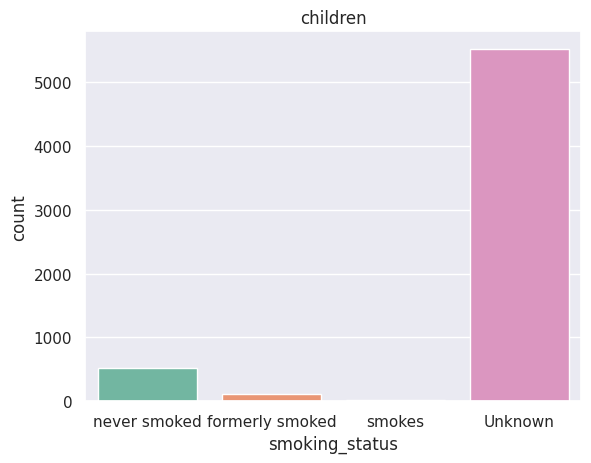

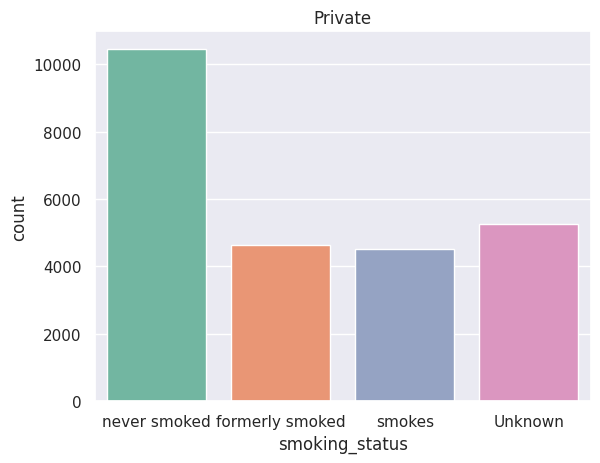

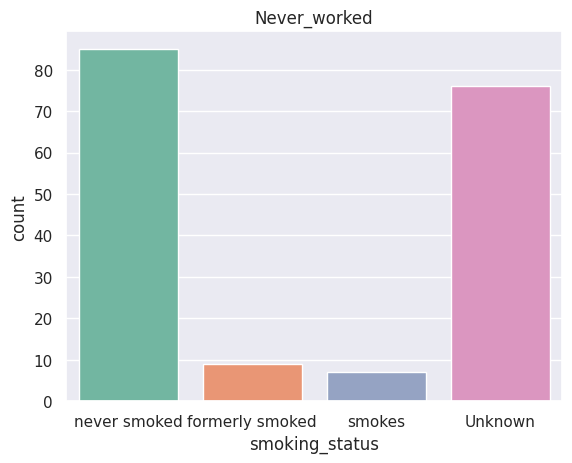

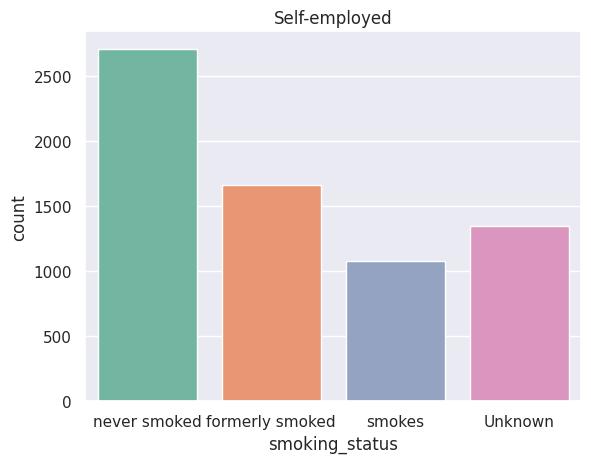

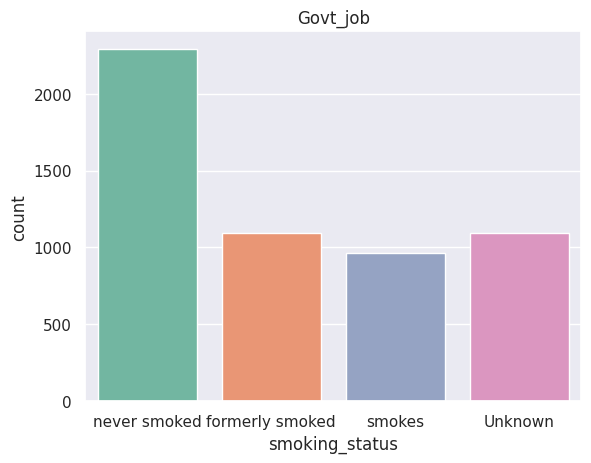

In [54]:
health_stroke_df_temp = df_stroke.copy()
health_stroke_df_temp.smoking_status.fillna('Unknown', inplace=True)

custom_palette = sns.color_palette("Set2")

for work in df_stroke.work_type.unique():
    sns.countplot(x='smoking_status', data=health_stroke_df_temp.groupby('work_type').get_group(work),
                  order=['never smoked', 'formerly smoked', 'smokes', 'Unknown'], palette=custom_palette)
    plt.title(work)
    plt.show()

Smoking status per gender class

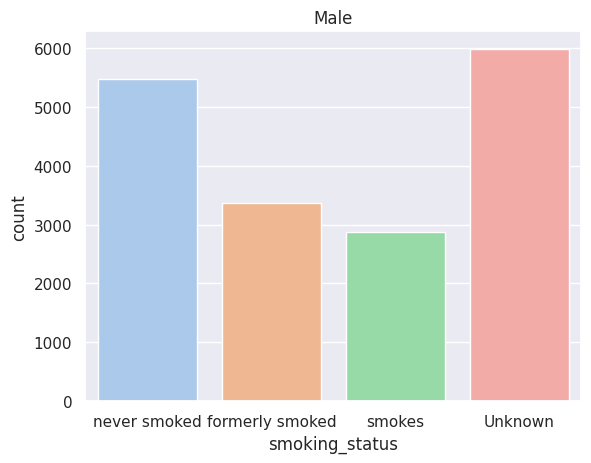

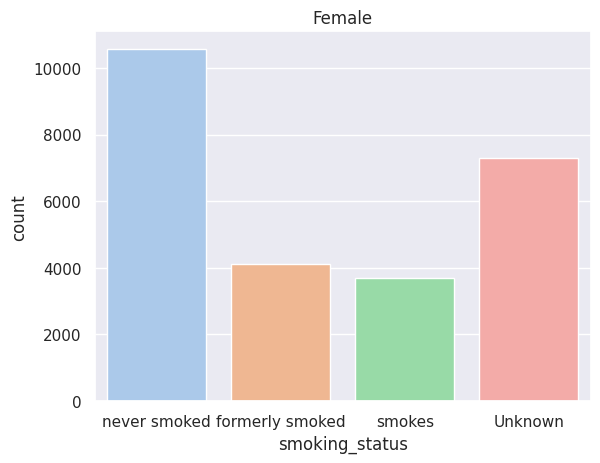

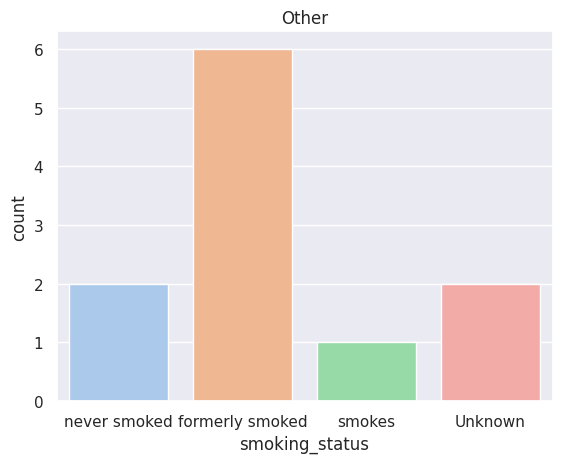

In [55]:
custom_palette = sns.color_palette("pastel")
for work in health_stroke_df_temp.gender.unique():
    sns.countplot(x='smoking_status', data=health_stroke_df_temp.groupby('gender').get_group(work),
                  order=['never smoked', 'formerly smoked', 'smokes', 'Unknown'], palette=custom_palette)
    plt.title(work)
    plt.show()

As examples, we have briefly checked how the smoking status are distributed for various gender or work_type classes. We can see in all these cases but gender=Other, smoking_status=never smoked always outnumbers other statuses. However the sample size for gender=Other is too small for comparison here.

**Drop 'id' column**

In [56]:
# Remove the 'id' from the DataFrame
df_stroke = df_stroke.drop('id', axis=1)

# Display the DataFrame after handling missing values and dropping the column
display(df_stroke.head())

gender   age hypertension heart_disease ever_married     work_type  \
0    Male   3.0            0             0           No      children   
1    Male  58.0            1             0          Yes       Private   
2  Female   8.0            0             0           No       Private   
3  Female  70.0            0             0          Yes       Private   
4    Male  14.0            0             0           No  Never_worked   

  Residence_type  avg_glucose_level   bmi   smoking_status stroke  
0          Rural              95.12  18.0          Unknown      0  
1          Urban              87.96  39.2     never smoked      0  
2          Urban             110.89  17.6          Unknown      0  
3          Rural              69.04  35.9  formerly smoked      0  
4          Rural             161.28  19.1          Unknown      0

<div id="remove_outliers">
    <h2>Remove Outliers</h2>    
</div>

In [57]:
# Drop common outliers (in both IQR and DBSCAN) from the main dataset
df_stroke.drop(index=common_outliers_df.index, inplace=True)

# Reset the index after dropping to keep it clean
df_stroke.reset_index(drop=True, inplace=True)

In [58]:
# Output the shape of the dataset after outlier detection
print(f'Dataset shape after removing outliers: {df_stroke.shape}')

Dataset shape after removing outliers: (43392, 11)


<div id="feature_discretization">
    <h2>Feature Discretization</h2>    
</div>

In [59]:
# Convert continuous feature into discrete intervals
# Discretize 'age' feature
def categorize_age(age):
    if age <= 18:
        return 'Child'            # 0-18 years
    elif age <= 35:
        return 'Young Adult'      # 19-35 years
    elif age <= 55:
        return 'Adult'            # 36-55 years
    else:
        return 'Senior'           # 56+ years

# Apply the function to create a new 'age_group' column
df_stroke['age_group'] = df_stroke['age'].apply(categorize_age)

In [60]:
# Discretize 'avg_glucose_level' feature
def categorize_glucose(glucose):
    if glucose < 100:
        return 'Normal'           # Glucose level < 100
    elif glucose <= 125:
        return 'Pre-diabetes'     # Glucose level between 100 and 125
    else:
        return 'Diabetes'         # Glucose level > 125

# Apply the function to create a new 'glucose_group' column
df_stroke['glucose_group'] = df_stroke['avg_glucose_level'].apply(categorize_glucose)

In [61]:
# Discretize 'bmi' feature
def categorize_bmi(bmi):
    if bmi < 18.5:
        return 'Underweight'      # BMI < 18.5
    elif bmi < 25:
        return 'Normal'           # BMI between 18.5 and 24.9
    elif bmi < 30:
        return 'Overweight'       # BMI between 25 and 29.9
    else:
        return 'Obese'            # BMI 30 or higher

# Apply the function to create a new 'bmi_group' column
df_stroke['bmi_group'] = df_stroke['bmi'].apply(categorize_bmi)

In [62]:
# Remove main columns -> 'age', 'avg_glucose_level', 'bmi'
df_stroke.drop(['age', 'avg_glucose_level', 'bmi'], axis=1, inplace=True)

print('Dataframe after discretization:')
display(df_stroke.head())

Dataframe after discretization:


gender hypertension heart_disease ever_married     work_type  \
0    Male            0             0           No      children   
1    Male            1             0          Yes       Private   
2  Female            0             0           No       Private   
3  Female            0             0          Yes       Private   
4    Male            0             0           No  Never_worked   

  Residence_type   smoking_status stroke age_group glucose_group    bmi_group  
0          Rural          Unknown      0     Child        Normal  Underweight  
1          Urban     never smoked      0    Senior        Normal        Obese  
2          Urban          Unknown      0     Child  Pre-diabetes  Underweight  
3          Rural  formerly smoked      0    Senior        Normal        Obese  
4          Rural          Unknown      0     Child      Diabetes       Normal

<div id="one_hot_encoding">
    <h2>One-hot Encoding</h2>    
</div>

In [63]:
# One-Hot Encoding for all categorical features
# Apply one-hot encoding using pd.get_dummies
# pd.get_dummies() converts categorical variables into dummy/indicator variables
# 'drop_first=False' means do not drop the first category of each variable
df_stroke_encoded = pd.get_dummies(df_stroke, drop_first=False)

# Convert boolean columns to integers (0/1)
df_stroke_encoded = df_stroke_encoded.astype(int)

In [64]:
# Display the shape of the new DataFrame
print(f"\nShape of the dataset after one-hot encoding: {df_stroke_encoded.shape}\n")

# Display the encoded DataFrame
df_stroke_encoded.head()


Shape of the dataset after one-hot encoding: (43392, 33)



gender_Female  gender_Male  gender_Other  hypertension_0  hypertension_1  \
0              0            1             0               1               0   
1              0            1             0               0               1   
2              1            0             0               1               0   
3              1            0             0               1               0   
4              0            1             0               1               0   

   heart_disease_0  heart_disease_1  ever_married_No  ever_married_Yes  \
0                1                0                1                 0   
1                1                0                0                 1   
2                1                0                1                 0   
3                1                0                0                 1   
4                1                0                1                 0   

   work_type_Govt_job  ...  age_group_Child  age_group_Senior  \
0                   0  ...                1                 0   
1                   0  ...                0                 1   
2                   0  ...                1                 0   
3                   0  ...                0                 1   
4                   0  ...                1                 0   

   age_group_Young Adult  glucose_group_Diabetes  glucose_group_Normal  \
0                      0                       0                     1   
1                      0                       0                     1   
2                      0                       0                     0   
3                      0                       0                     1   
4                      0                       1                     0   

   glucose_group_Pre-diabetes  bmi_group_Normal  bmi_group_Obese  \
0                           0                 0                0   
1                           0                 0                1   
2                           1                 0                0   
3                           0                 0                1   
4                           0                 1                0   

   bmi_group_Overweight  bmi_group_Underweight  
0                     0                      1  
1                     0                      0  
2                     0                      1  
3                     0                      0  
4                     0                      0  

[5 rows x 33 columns]

In [65]:
df_stroke_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43392 entries, 0 to 43391
Data columns (total 33 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   gender_Female                   43392 non-null  int64
 1   gender_Male                     43392 non-null  int64
 2   gender_Other                    43392 non-null  int64
 3   hypertension_0                  43392 non-null  int64
 4   hypertension_1                  43392 non-null  int64
 5   heart_disease_0                 43392 non-null  int64
 6   heart_disease_1                 43392 non-null  int64
 7   ever_married_No                 43392 non-null  int64
 8   ever_married_Yes                43392 non-null  int64
 9   work_type_Govt_job              43392 non-null  int64
 10  work_type_Never_worked          43392 non-null  int64
 11  work_type_Private               43392 non-null  int64
 12  work_type_Self-employed         43392 non-null  int64
 13  w

<hr>
<div id="association_rule_mining">
    <h2>Association Rule Mining</h2>    
</div>
<div>
    <ol>
        <li><a href="#apriori_algorithm">Apriori Algorithm</a></li>        
        <li><a href="#fpgrowth_algorithm">FP-Growth Algorithm</a></li>            
    </ol>
</div>
<br>

<hr>
<div id="apriori_algorithm">
    <h2>Apriori Algorithm</h2>    
</div>

The **Apriori Algorithm** is a method used in data mining to identify frequently occurring itemsets in datasets and to derive association rules.  

- What It Does:  

    - **Finds Frequent Itemsets**: Identifies sets of items that appear together in a dataset more often than a specified threshold (minimum support).  
    - **Generates Association Rules**: Creates rules that show relationships between items, which can help in understanding patterns.  

- How It Works:  

    1. **Generate Candidates**: Start with individual items and generate larger itemsets from them.  
    2. **Prune Non-Frequent Itemsets**: Remove itemsets that do not meet the minimum support threshold.  
    3. **Repeat**: Continue until no more frequent itemsets can be found.  

- Interpretation:  

    - **Support**: Measures how often an itemset appears in the dataset.  
    - **Confidence**: Indicates how often the rule is correct.  
    - **Lift**: Shows how much more likely the RHS item is given the LHS item.  

In [66]:
# Apply the Apriori algorithm to find frequent itemsets
# Set a minimum support threshold (e.g., 0.05 means the itemset appears in at least 5% of the transactions)
frequent_itemsets_apriori = apriori(
    df_stroke_encoded,
    min_support=0.05,
    use_colnames=True,     # Whether to use column names of the DataFrame instead of integer indices
    max_len=5              # Maximum length of the itemsets to be generated (up to 5 items)
)

# Display the frequent itemsets
print("\nFrequent Itemsets using Apriori:\n")
display(frequent_itemsets_apriori)


Frequent Itemsets using Apriori:



support                                           itemsets
0     0.591399                                    (gender_Female)
1     0.408347                                      (gender_Male)
2     0.906504                                   (hypertension_0)
3     0.093496                                   (hypertension_1)
4     0.952480                                  (heart_disease_0)
...        ...                                                ...
5101  0.088565  (glucose_group_Normal, age_group_Child, stroke...
5102  0.051530  (bmi_group_Normal, age_group_Child, stroke_0, ...
5103  0.061279  (age_group_Child, bmi_group_Underweight, strok...
5104  0.050585  (glucose_group_Normal, Residence_type_Rural, a...
5105  0.050724  (glucose_group_Normal, Residence_type_Urban, a...

[5106 rows x 2 columns]

In [67]:
# Generate association rules from the frequent itemsets
# Set a minimum confidence threshold (e.g., 0.6 means 60% confidence)
rules_apriori = association_rules(frequent_itemsets_apriori, metric="confidence", min_threshold=0.6)

# Sort rules by confidence value
rules_apriori = rules_apriori.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print("\nAssociation Rules using Apriori (Sorted by Confidence):\n")
display(rules_apriori)


Association Rules using Apriori (Sorted by Confidence):



antecedents  \
18947  (bmi_group_Underweight, smoking_status_Unknown...   
19303  (stroke_0, Residence_type_Urban, work_type_chi...   
19292  (Residence_type_Rural, stroke_0, work_type_chi...   
3499   (heart_disease_0, hypertension_0, work_type_ch...   
3469   (gender_Male, age_group_Child, smoking_status_...   
...                                                  ...   
6999   (ever_married_Yes, stroke_0, glucose_group_Dia...   
8268   (heart_disease_0, hypertension_0, bmi_group_Ob...   
9557   (heart_disease_0, stroke_0, ever_married_Yes, ...   
10354  (Residence_type_Rural, ever_married_Yes, gende...   
9536   (ever_married_Yes, stroke_0, glucose_group_Nor...   

                            consequents  antecedent support  \
18947                        (stroke_0)            0.062431   
19303                 (age_group_Child)            0.063860   
19292                 (age_group_Child)            0.063399   
3499                  (ever_married_No)            0.141708   
3469                         (stroke_0)            0.074899   
...                                 ...                 ...   
6999                (work_type_Private)            0.134841   
8268          (stroke_0, gender_Female)            0.304711   
9557                    (gender_Female)            0.267768   
10354  (stroke_0, glucose_group_Normal)            0.193538   
9536   (heart_disease_0, gender_Female)            0.375991   

       consequent support   support  confidence      lift  representativity  \
18947            0.981955  0.062431    1.000000  1.018376               1.0   
19303            0.185195  0.063860    1.000000  5.399701               1.0   
19292            0.185195  0.063399    1.000000  5.399701               1.0   
3499             0.356241  0.141708    1.000000  2.807090               1.0   
3469             0.981955  0.074899    1.000000  1.018376               1.0   
...                   ...       ...         ...       ...               ...   
6999             0.572179  0.080914    0.600068  1.048742               1.0   
8268             0.581467  0.182845    0.600061  1.031978               1.0   
9557             0.591399  0.160675    0.600052  1.014630               1.0   
10354            0.616842  0.116127    0.600024  0.972735               1.0   
9536             0.571903  0.225595    0.600000  1.049130               1.0   

       leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
18947  0.001127         inf       0.019246  0.063578   1.000000    0.531789  
19303  0.052033         inf       0.870387  0.344823   1.000000    0.672412  
19292  0.051658         inf       0.869959  0.342334   1.000000    0.671167  
3499   0.091226         inf       0.750047  0.397788   1.000000    0.698894  
3469   0.001352         inf       0.019506  0.076275   1.000000    0.538137  
...         ...         ...            ...       ...        ...         ...  
6999   0.003761    1.069735       0.053720  0.129233   0.065189    0.370741  
8268   0.005666    1.046492       0.044567  0.259969   0.044426    0.457257  
9557   0.002317    1.021634       0.019692  0.230031   0.021175    0.435869  
10354 -0.003255    0.957952      -0.033588  0.167270  -0.043893    0.394143  
9536   0.010564    1.070243       0.075045  0.312329   0.065633    0.497232  

[19368 rows x 14 columns]

In [68]:
# Filter rules for stronger insights
# Apply multiple conditions to filter the rules
# Keep only rules where:
# - lift > 1.2 (stronger association than random)
# - support > 0.05 (appears in at least 5% of transactions)
# - confidence > 0.6 (more than 60% of the time the rule is true)
filtered_rules_apriori = rules_apriori[
    (rules_apriori['lift'] > 1.2) &
    (rules_apriori['support'] > 0.05) &
    (rules_apriori['confidence'] > 0.6)
]

# Sort the filtered rules by confidence
filtered_rules_apriori = filtered_rules_apriori.sort_values(by='confidence', ascending=False)

# Display the result
print("\nFiltered Association Rules using Apriori (based on lift, support, and confidence):\n")
display(filtered_rules_apriori)


Filtered Association Rules using Apriori (based on lift, support, and confidence):



antecedents  \
3297   (gender_Male, age_group_Child, work_type_child...   
12161  (heart_disease_0, hypertension_0, work_type_ch...   
12149  (heart_disease_0, hypertension_0, work_type_ch...   
12180  (bmi_group_Normal, hypertension_0, work_type_c...   
16125  (stroke_0, Residence_type_Urban, work_type_chi...   
...                                                  ...   
10673                     (gender_Male, ever_married_No)   
13443            (age_group_Adult, glucose_group_Normal)   
7889                    (age_group_Adult, gender_Female)   
16584  (heart_disease_0, work_type_Private, ever_marr...   
6791   (Residence_type_Rural, stroke_0, smoking_statu...   

                                             consequents  antecedent support  \
3297                                   (ever_married_No)            0.073193   
12161                                  (ever_married_No)            0.098728   
12149                 (age_group_Child, ever_married_No)            0.141708   
12180                 (heart_disease_0, ever_married_No)            0.059020   
16125                                  (age_group_Child)            0.070796   
...                                                  ...                 ...   
10673  (heart_disease_0, hypertension_0, age_group_Ch...            0.152747   
13443  (heart_disease_0, hypertension_0, work_type_Pr...            0.185795   
7889   (heart_disease_0, hypertension_0, work_type_Pr...            0.179941   
16584                            (age_group_Young Adult)            0.111034   
6791                                   (ever_married_No)            0.151848   

       consequent support   support  confidence      lift  representativity  \
3297             0.356241  0.073193    1.000000  2.807090               1.0   
12161            0.356241  0.098728    1.000000  2.807090               1.0   
12149            0.185034  0.141708    1.000000  5.404409               1.0   
12180            0.352438  0.059020    1.000000  2.837377               1.0   
16125            0.185195  0.070796    1.000000  5.399701               1.0   
...                   ...       ...         ...       ...               ...   
10673            0.184988  0.092114    0.603048  3.259928               1.0   
13443            0.497580  0.111956    0.602580  1.211021               1.0   
7889             0.497580  0.108315    0.601947  1.209748               1.0   
16584            0.204300  0.066833    0.601910  2.946199               1.0   
6791             0.356241  0.091192    0.600546  1.685788               1.0   

       leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
3297   0.047119         inf       0.694599  0.205460   1.000000    0.602730  
12161  0.063557         inf       0.714278  0.277138   1.000000    0.638569  
12149  0.115487         inf       0.949521  0.765849   1.000000    0.882924  
12180  0.038219         inf       0.688178  0.167462   1.000000    0.583731  
16125  0.057685         inf       0.876885  0.382280   1.000000    0.691140  
...         ...         ...            ...       ...        ...         ...  
10673  0.063857    2.053173       0.818226  0.375023   0.512949    0.550496  
13443  0.019508    1.264204       0.214013  0.195927   0.208988    0.413791  
7889   0.018780    1.262192       0.211426  0.190291   0.207728    0.409815  
16584  0.044148    1.998791       0.743088  0.268942   0.499698    0.464519  
6791   0.037097    1.611599       0.479638  0.218740   0.379498    0.428265  

[5329 rows x 14 columns]

In [69]:
# Filter the sorted rules to get only those with 'hypertension_1' in the antecedents
# Select the relevant columns: 'antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage', and 'conviction'
R_hypertension_1_apriori = filtered_rules_apriori[filtered_rules_apriori['antecedents'] ==
                                  {'hypertension_1'}].loc[:, ['antecedents', 'consequents', 'support',
                                                              'confidence', 'lift', 'leverage', 'conviction']]

# Sort the filtered results by 'confidence' in descending order
R_hypertension_1_apriori = R_hypertension_1_apriori.sort_values(by = 'confidence', ascending=False)

# Display output
print("\nDisplay the final sorted DataFrame containing the rules for hypertension_1 using Apriori:\n")
display(R_hypertension_1_apriori)


Display the final sorted DataFrame containing the rules for hypertension_1 using Apriori:



antecedents                                    consequents  \
49    (hypertension_1)                             (ever_married_Yes)   
869   (hypertension_1)                   (ever_married_Yes, stroke_0)   
861   (hypertension_1)            (ever_married_Yes, heart_disease_0)   
5398  (hypertension_1)  (ever_married_Yes, stroke_0, heart_disease_0)   
51    (hypertension_1)                             (age_group_Senior)   
876   (hypertension_1)                   (age_group_Senior, stroke_0)   
872   (hypertension_1)           (ever_married_Yes, age_group_Senior)   

       support  confidence      lift  leverage  conviction  
49    0.084808    0.907074  1.409027  0.024619    3.833604  
869   0.080798    0.864185  1.377060  0.022124    2.742281  
861   0.073862    0.789993  1.316563  0.017760    1.904497  
5398  0.070820    0.757456  1.289277  0.015890    1.700705  
51    0.062684    0.670446  2.121645  0.033139    2.075524  
876   0.058628    0.627064  2.084546  0.030503    1.874812  
872   0.058421    0.624846  2.128872  0.030979    1.883199

<hr>
<div id="fpgrowth_algorithm">
    <h2>FP-Growth Algorithm</h2>    
</div>
  
The **FP-Growth (Frequent Pattern Growth) algorithm** is a popular method used in data mining for discovering frequent itemsets in datasets. It is particularly efficient and scalable, making it suitable for large datasets where other algorithms, like Apriori, might struggle due to their computational intensity.  

- What It Does:

    - **Find Frequent Itemsets**: Locates subsets of items (itemsets) that appear together in a dataset with a frequency higher than a specified threshold (minimum support).
    - **Analyze Useful Patterns**: Analyzes patterns to extract meaningful insights and implications.
    - **Generate Association Rules**: Allows the creation of rules that highlight relationships between items.

- How It Works:

    1. **Create the FP-tree**:  
    - **Scan the Database**: Perform a first pass over the dataset to identify the frequency of each item. This creates a list of items sorted by their frequency (support).  
    - **Build the FP-tree**: Construct a compact data structure (FP-tree) that retains the itemset information in a way that allows for efficient pattern mining. The FP-tree consists of:  
        - A header table that keeps track of item frequencies.  
        - A tree structure where each node represents an item, and paths in the tree represent data entries.  

    2. **Generate Frequent Itemsets**:  
    - **Conditional Pattern Base**: For each item in the header table, extract its conditional pattern base.  
    - **Conditional FP-tree**: Build a conditional FP-tree for each item using its conditional pattern base.  
    - **Recursion**: Recursively mine the conditional FP-trees for frequent patterns.   

In [70]:
# Apply the FP-Growth algorithm to find frequent itemsets
# Set a minimum support threshold (e.g., 0.05 means the itemset appears in at least 5% of the transactions)
frequent_itemsets_fpgrowth = fpgrowth(
    df_stroke_encoded,
    min_support=0.05,
    use_colnames=True,     # Whether to use column names of the DataFrame instead of integer indices
    max_len=5              # Maximum length of the itemsets to be generated (up to 5 items)
)

# Display the frequent itemsets
print("\nFrequent Itemsets using FP-Growth:\n")
display(frequent_itemsets_fpgrowth)


Frequent Itemsets using FP-Growth:



support                                           itemsets
0     0.981955                                         (stroke_0)
1     0.952480                                  (heart_disease_0)
2     0.906504                                   (hypertension_0)
3     0.625207                             (glucose_group_Normal)
4     0.498709                             (Residence_type_Rural)
...        ...                                                ...
5101  0.053627  (heart_disease_0, hypertension_0, Residence_ty...
5102  0.053028  (work_type_Govt_job, Residence_type_Rural, hea...
5103  0.051968  (stroke_0, smoking_status_never smoked, work_t...
5104  0.051162  (heart_disease_0, smoking_status_never smoked,...
5105  0.050447  (heart_disease_0, stroke_0, smoking_status_nev...

[5106 rows x 2 columns]

In [71]:
# Generate association rules based on the frequent itemsets
# Set a minimum confidence threshold (e.g., 0.6 means 60% confidence)
rules_fpgrowth = association_rules(frequent_itemsets_fpgrowth, metric="confidence", min_threshold=0.6)

# Sort rules by confidence value
rules_fpgrowth = rules_fpgrowth.sort_values(by='confidence', ascending=False)

# Display the sorted rules
print("\nAssociation Rules using FP-Growth (Sorted by Confidence):\n")
display(rules_fpgrowth)


Association Rules using FP-Growth (Sorted by Confidence):



antecedents  \
4236   (heart_disease_0, hypertension_0, work_type_ch...   
4359   (stroke_0, ever_married_No, work_type_children...   
5823   (smoking_status_Unknown, work_type_children, g...   
5808   (smoking_status_Unknown, hypertension_0, work_...   
5813   (smoking_status_Unknown, work_type_children, g...   
...                                                  ...   
13494  (ever_married_Yes, stroke_0, glucose_group_Dia...   
9755   (heart_disease_0, hypertension_0, bmi_group_Ob...   
9769   (heart_disease_0, stroke_0, ever_married_Yes, ...   
280    (Residence_type_Rural, ever_married_Yes, gende...   
11171  (ever_married_Yes, stroke_0, glucose_group_Nor...   

                             consequents  antecedent support  \
4236                   (age_group_Child)            0.127189   
4359                   (age_group_Child)            0.098797   
5823   (hypertension_0, ever_married_No)            0.060956   
5808                   (age_group_Child)            0.060956   
5813   (hypertension_0, age_group_Child)            0.060956   
...                                  ...                 ...   
13494                (work_type_Private)            0.134841   
9755           (stroke_0, gender_Female)            0.304711   
9769                     (gender_Female)            0.267768   
280     (stroke_0, glucose_group_Normal)            0.193538   
11171   (heart_disease_0, gender_Female)            0.375991   

       consequent support   support  confidence      lift  representativity  \
4236             0.185195  0.127189    1.000000  5.399701               1.0   
4359             0.185195  0.098797    1.000000  5.399701               1.0   
5823             0.347553  0.060956    1.000000  2.877263               1.0   
5808             0.185195  0.060956    1.000000  5.399701               1.0   
5813             0.185080  0.060956    1.000000  5.403063               1.0   
...                   ...       ...         ...       ...               ...   
13494            0.572179  0.080914    0.600068  1.048742               1.0   
9755             0.581467  0.182845    0.600061  1.031978               1.0   
9769             0.591399  0.160675    0.600052  1.014630               1.0   
280              0.616842  0.116127    0.600024  0.972735               1.0   
11171            0.571903  0.225595    0.600000  1.049130               1.0   

       leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
4236   0.103634         inf       0.933541  0.686784   1.000000    0.843392  
4359   0.080500         inf       0.904130  0.533474   1.000000    0.766737  
5823   0.039771         inf       0.694800  0.175386   1.000000    0.587693  
5808   0.049667         inf       0.867696  0.329144   1.000000    0.664572  
5813   0.049674         inf       0.867818  0.329349   1.000000    0.664674  
...         ...         ...            ...       ...        ...         ...  
13494  0.003761    1.069735       0.053720  0.129233   0.065189    0.370741  
9755   0.005666    1.046492       0.044567  0.259969   0.044426    0.457257  
9769   0.002317    1.021634       0.019692  0.230031   0.021175    0.435869  
280   -0.003255    0.957952      -0.033588  0.167270  -0.043893    0.394143  
11171  0.010564    1.070243       0.075045  0.312329   0.065633    0.497232  

[19368 rows x 14 columns]

In [72]:
# Filter rules for stronger insights
# Apply multiple conditions to filter the rules
# Keep only rules where:
# - lift > 1.2 (stronger association than random)
# - support > 0.05 (appears in at least 5% of transactions)
# - confidence > 0.6 (more than 60% of the time the rule is true)
filtered_rules_fpgrowth = rules_fpgrowth[
    (rules_fpgrowth['lift'] > 1.2) &
    (rules_fpgrowth['support'] > 0.05) &
    (rules_fpgrowth['confidence'] > 0.6)
]

# Sort the filtered rules by confidence
filtered_rules_fpgrowth = filtered_rules_fpgrowth.sort_values(by='confidence', ascending=False)

# Display the result
print("\nFiltered Association Rules using FP-Growth (based on lift, support, and confidence):\n")
display(filtered_rules_fpgrowth)


Filtered Association Rules using FP-Growth (based on lift, support, and confidence):



antecedents  \
6010              (bmi_group_Normal, work_type_children)   
4278   (heart_disease_0, stroke_0, work_type_children...   
4377   (hypertension_0, work_type_children, glucose_g...   
5859   (smoking_status_Unknown, work_type_children, g...   
5308   (Residence_type_Rural, ever_married_No, work_t...   
...                                                  ...   
3016                      (gender_Male, ever_married_No)   
14744            (age_group_Adult, glucose_group_Normal)   
14023                   (age_group_Adult, gender_Female)   
18009  (heart_disease_0, work_type_Private, ever_marr...   
1736   (Residence_type_Rural, stroke_0, smoking_statu...   

                                             consequents  antecedent support  \
6010   (heart_disease_0, hypertension_0, age_group_Ch...            0.059020   
4278                                   (age_group_Child)            0.127166   
4377                                   (age_group_Child)            0.098797   
5859                  (heart_disease_0, age_group_Child)            0.060956   
5308                                   (age_group_Child)            0.063422   
...                                                  ...                 ...   
3016   (heart_disease_0, hypertension_0, age_group_Ch...            0.152747   
14744  (heart_disease_0, hypertension_0, work_type_Pr...            0.185795   
14023  (heart_disease_0, hypertension_0, work_type_Pr...            0.179941   
18009                            (age_group_Young Adult)            0.111034   
1736                                   (ever_married_No)            0.151848   

       consequent support   support  confidence      lift  representativity  \
6010             0.184988  0.059020    1.000000  5.405756               1.0   
4278             0.185195  0.127166    1.000000  5.399701               1.0   
4377             0.185195  0.098797    1.000000  5.399701               1.0   
5859             0.185103  0.060956    1.000000  5.402390               1.0   
5308             0.185195  0.063422    1.000000  5.399701               1.0   
...                   ...       ...         ...       ...               ...   
3016             0.184988  0.092114    0.603048  3.259928               1.0   
14744            0.497580  0.111956    0.602580  1.211021               1.0   
14023            0.497580  0.108315    0.601947  1.209748               1.0   
18009            0.204300  0.066833    0.601910  2.946199               1.0   
1736             0.356241  0.091192    0.600546  1.685788               1.0   

       leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
6010   0.048102         inf       0.866131  0.319048   1.000000    0.659524  
4278   0.103616         inf       0.933516  0.686660   1.000000    0.843330  
4377   0.080500         inf       0.904130  0.533474   1.000000    0.766737  
5859   0.049673         inf       0.867794  0.329308   1.000000    0.664654  
5308   0.051676         inf       0.869980  0.342459   1.000000    0.671229  
...         ...         ...            ...       ...        ...         ...  
3016   0.063857    2.053173       0.818226  0.375023   0.512949    0.550496  
14744  0.019508    1.264204       0.214013  0.195927   0.208988    0.413791  
14023  0.018780    1.262192       0.211426  0.190291   0.207728    0.409815  
18009  0.044148    1.998791       0.743088  0.268942   0.499698    0.464519  
1736   0.037097    1.611599       0.479638  0.218740   0.379498    0.428265  

[5329 rows x 14 columns]

In [73]:
# Filter the sorted rules to get only those with 'hypertension_1' in the antecedents
# Select the relevant columns: 'antecedents', 'consequents', 'support', 'confidence', 'lift', 'leverage', and 'conviction'
R_hypertension_1_fpgrowth = filtered_rules_fpgrowth[filtered_rules_fpgrowth['antecedents'] ==
                                  {'hypertension_1'}].loc[:, ['antecedents', 'consequents', 'support',
                                                              'confidence', 'lift', 'leverage', 'conviction']]

# Sort the filtered results by 'confidence' in descending order
R_hypertension_1_fpgrowth = R_hypertension_1_fpgrowth.sort_values(by = 'confidence', ascending=False)

# Display output
print("\nDisplay the final sorted DataFrame containing the rules for hypertension_1 using FP-Growth:\n")
display(R_hypertension_1_fpgrowth)


Display the final sorted DataFrame containing the rules for hypertension_1 using FP-Growth:



antecedents                                    consequents  \
10996  (hypertension_1)                             (ever_married_Yes)   
11001  (hypertension_1)                   (ever_married_Yes, stroke_0)   
11007  (hypertension_1)            (ever_married_Yes, heart_disease_0)   
11014  (hypertension_1)  (ever_married_Yes, stroke_0, heart_disease_0)   
10998  (hypertension_1)                             (age_group_Senior)   
11017  (hypertension_1)                   (age_group_Senior, stroke_0)   
11020  (hypertension_1)           (ever_married_Yes, age_group_Senior)   

        support  confidence      lift  leverage  conviction  
10996  0.084808    0.907074  1.409027  0.024619    3.833604  
11001  0.080798    0.864185  1.377060  0.022124    2.742281  
11007  0.073862    0.789993  1.316563  0.017760    1.904497  
11014  0.070820    0.757456  1.289277  0.015890    1.700705  
10998  0.062684    0.670446  2.121645  0.033139    2.075524  
11017  0.058628    0.627064  2.084546  0.030503    1.874812  
11020  0.058421    0.624846  2.128872  0.030979    1.883199